Total mesh area: 50566.36 sq m. Sampling 10113 points (0.2/sq m)


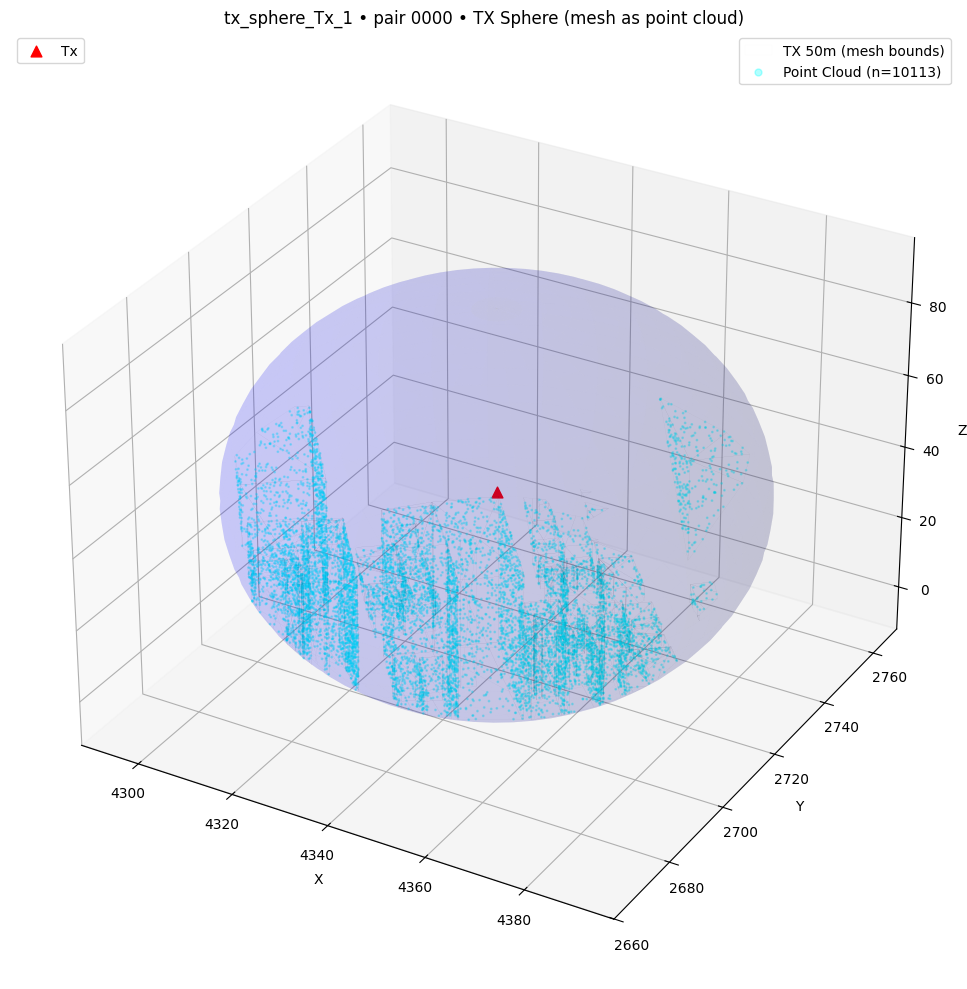

In [1]:
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

# Point this at any extracted pair folder, e.g.
#   /.../extracted_regions/train/7GHz_Tx_1/
#   /.../extracted_regions/7GHz_Tx_12/
BASE_DIR_FOR_PLOT = Path("/home/mkrishne/PL_competition/extracted_regions/train/tx_sphere_Tx_1/")
PAIR_IDX_FOR_PLOT = 0  # which pair to visualize

# NEW: Define a point DENSITY, not a fixed total number
POINTS_PER_SQUARE_METER = 0.2 # How many points to sample for every 1 sq meter of surface area

# ---------- I/O helpers ----------
def _npz_path(base_dir: Path, pair_idx: int, tag: str) -> Path:
    return base_dir / f"pair{pair_idx:05d}_{tag}.npz"

def _load_region(base_dir: Path, pair_idx: int, tag: str):
    path = _npz_path(base_dir, pair_idx, tag)
    if not path.exists():
        raise FileNotFoundError(f"Missing file: {path}")
    dat = np.load(path, allow_pickle=True)
    polys = [p for p in dat["polys"] if p is not None and len(p) >= 3]
    meta  = {k: dat[k] for k in dat.files if k != "polys"}
    # be safe about dtypes/shapes
    meta["Tx"] = np.array(meta["Tx"], dtype=float).reshape(-1)
    return polys, meta

# ---------- Surfaces ----------
def _sphere_surface(C, R, n_theta=36, n_phi=60):
    theta = np.linspace(0.0, np.pi, n_theta)
    phi   = np.linspace(0.0, 2.0*np.pi, n_phi)
    T, P  = np.meshgrid(theta, phi)
    X = C[0] + R*np.sin(T)*np.cos(P)
    Y = C[1] + R*np.sin(T)*np.sin(P)
    Z = C[2] + R*np.cos(T)
    return X, Y, Z

# Note: _fresnel_ellipsoid_surface is no longer called, but left for completeness
def _fresnel_ellipsoid_surface(T, Tx, Rx, n_theta=48, n_phi=80):
    D = float(np.linalg.norm(Rx - Tx))
    a = T/2.0
    c = D/2.0
    b = np.sqrt(max(a*a - c*c, 0.0))
    center = 0.5*(Tx + Rx)
    theta = np.linspace(0.0, np.pi, n_theta)
    phi   = np.linspace(0.0, 2.0*np.pi, n_phi)
    Tm, Pm = np.meshgrid(theta, phi)
    Xloc = a * np.cos(Tm)
    Yloc = b * np.sin(Tm) * np.cos(Pm)
    Zloc = b * np.sin(Tm) * np.sin(Pm)
    u = (Rx - Tx) / (D + 1e-15)
    tmp = np.array([0.0,0.0,1.0]) if abs(np.dot(u,[0,0,1])) < 0.9 else np.array([0.0,1.0,0.0])
    v = np.cross(u, tmp); v /= (np.linalg.norm(v) + 1e-15)
    w = np.cross(u, v)
    X = center[0] + Xloc*u[0] + Yloc*v[0] + Zloc*w[0]
    Y = center[1] + Xloc*u[1] + Yloc*v[1] + Zloc*w[1]
    Z = center[2] + Xloc*u[2] + Yloc*v[2] + Zloc*w[2]
    return X, Y, Z

# ---------- Point Cloud Sampling Helpers ----------

def _triangulate_polygon(poly):
    """Assumes a convex polygon and creates a triangle fan."""
    if len(poly) < 3:
        return []
    V0 = poly[0]
    triangles = []
    for i in range(1, len(poly) - 1):
        V1 = poly[i]
        V2 = poly[i+1]
        triangles.append((V0, V1, V2))
    return triangles

def sample_mesh_surface(polys, points_per_sq_meter):
    """
    Samples points from the surface of the mesh defined by polys.
    Total points sampled is proportional to the total surface area.
    """
    all_triangles = []
    triangle_areas = []
    total_area = 0.0
    
    # 1. Triangulate all polygons and calculate their total area
    for poly in polys:
        triangles_in_poly = _triangulate_polygon(poly)
        for tri in triangles_in_poly:
            V0, V1, V2 = tri
            # Area = 0.5 * | (V1-V0) x (V2-V0) |
            area = 0.5 * np.linalg.norm(np.cross(V1 - V0, V2 - V0))
            if area > 1e-9: # Avoid degenerate triangles
                all_triangles.append(tri)
                triangle_areas.append(area)
                total_area += area

    if total_area == 0:
        print("No valid triangle area found. Returning empty point cloud.")
        return np.array([]).reshape(0, 3)

    # --- THIS IS THE NEW LOGIC ---
    # 2. Calculate total points based on area and density
    total_points = int(np.round(total_area * points_per_sq_meter))
    
    if total_points == 0:
        print(f"Total area {total_area:.2f} sq_m is too small to generate points at {points_per_sq_meter}/sq_m.")
        return np.array([]).reshape(0, 3)

    print(f"Total mesh area: {total_area:.2f} sq m. Sampling {total_points} points ({points_per_sq_meter}/sq m)")
    # --- END OF NEW LOGIC ---

    # 3. Sample points from each triangle based on its area
    points_sampled = []
    num_triangles = len(all_triangles)
    
    # Distribute points based on area
    triangle_areas = np.array(triangle_areas)
    # This calculation remains the same, using the new 'total_points'
    points_per_triangle = np.round(total_points * (triangle_areas / total_area)).astype(int)
    
    # Adjust for rounding errors to ensure exact total_points
    diff = total_points - points_per_triangle.sum()
    if diff != 0:
        # Add/remove points from largest triangles
        indices_to_adjust = np.argsort(triangle_areas)[-abs(diff):]
        points_per_triangle[indices_to_adjust] += np.sign(diff)

    for i in range(num_triangles):
        num_points_for_this_tri = points_per_triangle[i]
        if num_points_for_this_tri == 0:
            continue
            
        V0, V1, V2 = all_triangles[i]
        
        # Uniform sampling within a triangle
        r1 = np.random.rand(num_points_for_this_tri)
        r2 = np.random.rand(num_points_for_this_tri)
        
        sqrt_r1 = np.sqrt(r1).reshape(-1, 1)
        r2 = r2.reshape(-1, 1)
        
        u = (1.0 - sqrt_r1)
        v = sqrt_r1 * (1.0 - r2)
        w = sqrt_r1 * r2
        
        points_on_tri = u * V0 + v * V1 + w * V2
        points_sampled.append(points_on_tri)

    if not points_sampled:
        print("No points sampled (this should be rare if total_points > 0).")
        return np.array([]).reshape(0, 3)

    return np.concatenate(points_sampled, axis=0)

# ---------- Main plotting ----------
def plot_folder(base_dir: Path, pair_idx: int = 0):
    # Load regions (TX sphere only)
    try:
        polys_TX, meta_TX = _load_region(base_dir, pair_idx, "tx_sphere50")
    except FileNotFoundError as e:
        print(e)
        print("Cannot plot. Exiting.")
        return

    # Shared metadata
    Tx = meta_TX["Tx"]
    R  = float(meta_TX["R"])  # 50 m

    # ----- Sample mesh to create point cloud -----
    # Pass the DENSITY, not a fixed total
    point_cloud = sample_mesh_surface(polys_TX, POINTS_PER_SQUARE_METER)
    
    # Surfaces
    Xs_tx, Ys_tx, Zs_tx = _sphere_surface(Tx, R)

    # For aspect ratio
    all_sets = []
    if polys_TX:  
        all_sets.append(np.concatenate(polys_TX, axis=0))
    if point_cloud.shape[0] > 0:
        all_sets.append(point_cloud)
        
    all_sets.extend([
        Tx[None,:],
        np.c_[Xs_tx.ravel(), Ys_tx.ravel(), Zs_tx.ravel()],
    ])
    
    if not all_sets:
        print("No data to plot (empty clipped region and no surface points).")
        return
        
    all_pts = np.concatenate(all_sets, axis=0)
    mins = all_pts.min(axis=0); maxs = all_pts.max(axis=0)

    # Plot
    fig = plt.figure(figsize=(12,10))
    ax = fig.add_subplot(111, projection='3d')

    # Plot Clipped TX Polygons
    if polys_TX:
        ax.add_collection(Poly3DCollection(
            polys_TX, facecolor=(0.2,0.2,0.85,0.0), edgecolor=(0.1,0.1,0.1,0.05), linewidths=0.1, 
            label='TX 50m (mesh bounds)'
        ))

    # Plot Full TX Sphere Surface
    ax.plot_surface(Xs_tx, Ys_tx, Zs_tx, alpha=0.1, linewidth=0, antialiased=True, color='blue')

    # ----- Plot Point Cloud -----
    if point_cloud.shape[0] > 0:
        # The label now dynamically shows the number of points, which will vary
        ax.scatter(
            point_cloud[:,0], point_cloud[:,1], point_cloud[:,2], 
            s=1, alpha=0.3, color='cyan', label=f'Point Cloud (n={point_cloud.shape[0]})'
        )
    # ---------------------------------

    # Plot TX Point
    ax.scatter([Tx[0]],[Tx[1]],[Tx[2]], s=60, marker='^', label='Tx', color='red')

    ax.set_xlabel('X'); ax.set_ylabel('Y'); ax.set_zlabel('Z')
    ax.set_title(f'{base_dir.name} • pair {pair_idx:04d} • TX Sphere (mesh as point cloud)')
    
    # ----- Set equal aspect ratio manually -----
    center = (maxs + mins) / 2.0
    span = maxs - mins
    max_span = np.max(span) * 1.1 
    
    ax.set_xlim(center[0] - max_span / 2.0, center[0] + max_span / 2.0)
    ax.set_ylim(center[1] - max_span / 2.0, center[1] + max_span / 2.0)
    ax.set_zlim(center[2] - max_span / 2.0, center[2] + max_span / 2.0)
        
    # ----- Handle legends separately -----
    handles, labels = ax.get_legend_handles_labels()
    
    tx_handles = []
    tx_labels = []
    other_handles = []
    other_labels = []
    
    for h, l in zip(handles, labels):
        if l == 'Tx':
            tx_handles.append(h)
            tx_labels.append(l)
        else:
            other_handles.append(h)
            other_labels.append(l)

    legend1 = ax.legend(other_handles, other_labels, loc='upper right', markerscale=5)
    
    if tx_handles:
        ax.add_artist(legend1) 
        ax.legend(tx_handles, tx_labels, loc='upper left', markerscale=1)
    
    plt.tight_layout(); plt.show()

# ---- Run ----
# Make sure to update BASE_DIR_FOR_PLOT to point to your data
if __name__ == "__main__":
    if not BASE_DIR_FOR_PLOT.exists():
        print(f"Error: Path not found. Please update BASE_DIR_FOR_PLOT in the script.")
        print(f"Current path: {BASE_DIR_FOR_PLOT}")
    else:
        plot_folder(BASE_DIR_FOR_PLOT, PAIR_IDX_FOR_PLOT)


Total mesh area: 19942.19 sq m. Sampling with grid step 3.162 m.
Sampled 1147 unique grid points.

=== Point Cloud Stats ===
X: min=4265.850, max=4361.250
Y: min=4314.360, max=4394.320
Z: min=20.410, max=68.800



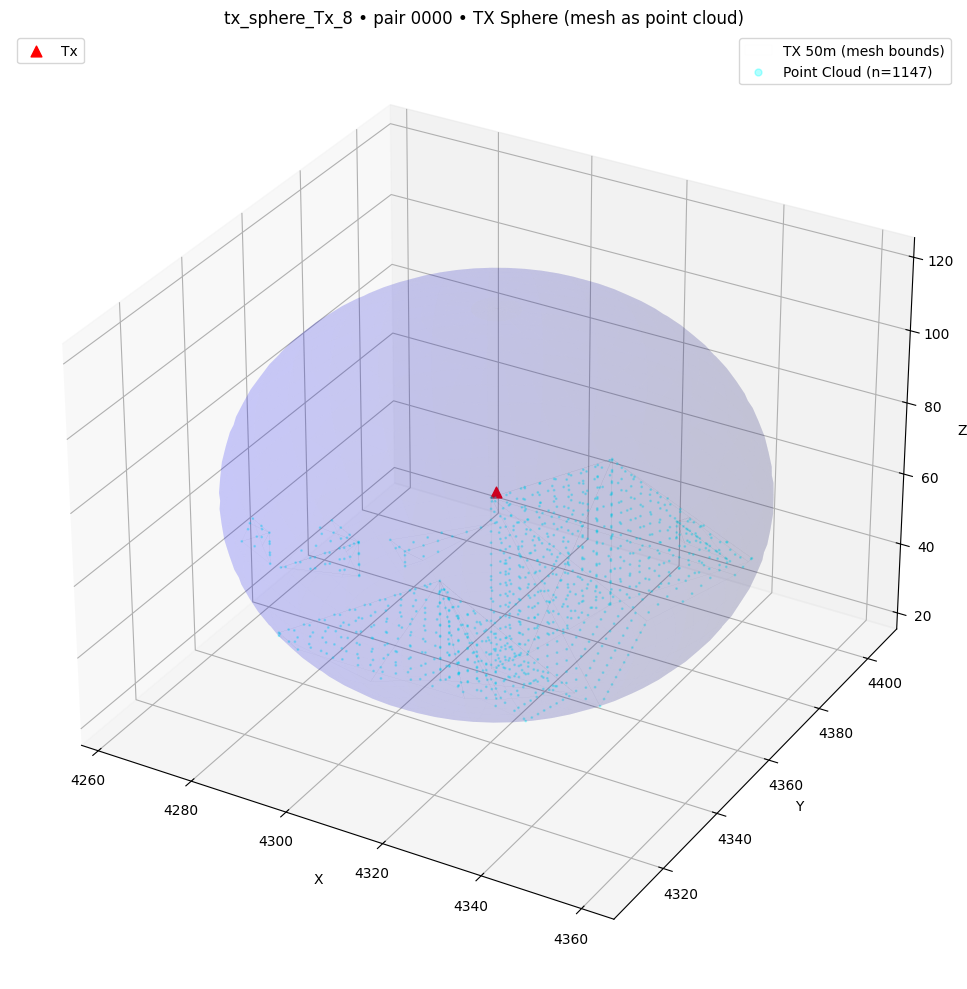

In [2]:
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

# Point this at any extracted pair folder, e.g.
#   /.../extracted_regions/train/7GHz_Tx_1/
#   /.../extracted_regions/7GHz_Tx_12/
# MODIFIED: Pointed back to the tx_sphere directory
BASE_DIR_FOR_PLOT = Path("/home/mkrishne/PL_competition/extracted_regions/train/tx_sphere_Tx_8/")
PAIR_IDX_FOR_PLOT = 0  # which pair to visualize

# NEW: Define a point DENSITY, not a fixed total number
POINTS_PER_SQUARE_METER = 0.1 # How many points to sample for every 1 sq meter of surface area

# ---------- I/O helpers ----------
def _npz_path(base_dir: Path, pair_idx: int, tag: str) -> Path:
    return base_dir / f"pair{pair_idx:05d}_{tag}.npz"

def _load_region(base_dir: Path, pair_idx: int, tag: str):
    path = _npz_path(base_dir, pair_idx, tag)
    if not path.exists():
        raise FileNotFoundError(f"Missing file: {path}")
    dat = np.load(path, allow_pickle=True)
    polys = [p for p in dat["polys"] if p is not None and len(p) >= 3]
    meta  = {k: dat[k] for k in dat.files if k != "polys"}
    # be safe about dtypes/shapes
    meta["Tx"] = np.array(meta["Tx"], dtype=float).reshape(-1)
    # MODIFIED: Load Rx if it exists (but won't be used for sphere plot)
    if "Rx" in meta:
        meta["Rx"] = np.array(meta["Rx"], dtype=float).reshape(-1)
    return polys, meta

# ---------- Surfaces ----------
def _sphere_surface(C, R, n_theta=36, n_phi=60):
    theta = np.linspace(0.0, np.pi, n_theta)
    phi   = np.linspace(0.0, 2.0*np.pi, n_phi)
    T, P  = np.meshgrid(theta, phi)
    X = C[0] + R*np.sin(T)*np.cos(P)
    Y = C[1] + R*np.sin(T)*np.sin(P)
    Z = C[2] + R*np.cos(T)
    return X, Y, Z

# Note: _fresnel_ellipsoid_surface is no longer called, but left for completeness
def _fresnel_ellipsoid_surface(T, Tx, Rx, n_theta=48, n_phi=80):
    D = float(np.linalg.norm(Rx - Tx))
    a = T/2.0
    c = D/2.0
    b = np.sqrt(max(a*a - c*c, 0.0))
    center = 0.5*(Tx + Rx)
    theta = np.linspace(0.0, np.pi, n_theta)
    phi   = np.linspace(0.0, 2.0*np.pi, n_phi)
    Tm, Pm = np.meshgrid(theta, phi)
    Xloc = a * np.cos(Tm)
    Yloc = b * np.sin(Tm) * np.cos(Pm)
    Zloc = b * np.sin(Tm) * np.sin(Pm)
    u = (Rx - Tx) / (D + 1e-15)
    tmp = np.array([0.0,0.0,1.0]) if abs(np.dot(u,[0,0,1])) < 0.9 else np.array([0.0,1.0,0.0])
    v = np.cross(u, tmp); v /= (np.linalg.norm(v) + 1e-15)
    w = np.cross(u, v)
    X = center[0] + Xloc*u[0] + Yloc*v[0] + Zloc*w[0]
    Y = center[1] + Xloc*u[1] + Yloc*v[1] + Zloc*w[1]
    Z = center[2] + Xloc*u[2] + Yloc*v[2] + Zloc*w[2]
    return X, Y, Z

# ---------- Point Cloud Sampling Helpers ----------

def _triangulate_polygon(poly):
    """Assumes a convex polygon and creates a triangle fan."""
    if len(poly) < 3:
        return []
    V0 = poly[0]
    triangles = []
    for i in range(1, len(poly) - 1):
        V1 = poly[i]
        V2 = poly[i+1]
        triangles.append((V0, V1, V2))
    return triangles

def _point_in_triangle_2d(pt, v0, v1, v2):
    """
    Checks if a 2D point is inside a 2D triangle.
    Uses the "Sign of Half-Planes" method (robust and fast).
    """
    def sign(p1, p2, p3):
        return (p1[0] - p3[0]) * (p2[1] - p3[1]) - (p2[0] - p3[0]) * (p1[1] - p3[1])

    d1 = sign(pt, v0, v1)
    d2 = sign(pt, v1, v2)
    d3 = sign(pt, v2, v0)

    # Check for floating point inaccuracies near zero
    has_neg = (d1 < -1e-9) or (d2 < -1e-9) or (d3 < -1e-9)
    has_pos = (d1 > 1e-9) or (d2 > 1e-9) or (d3 > 1e-9)

    # Point is inside or on the edge if all signs are the same
    return not (has_neg and has_pos)

def sample_mesh_surface(polys, points_per_sq_meter):
    """
    MODIFIED: Samples points from the surface of the mesh using a UNIFORM GRID.
    Total points sampled is proportional to the total surface area.
    """
    all_triangles = []
    total_area = 0.0
    
    # 1. Triangulate all polygons and calculate their total area
    for poly in polys:
        triangles_in_poly = _triangulate_polygon(poly)
        for tri in triangles_in_poly:
            V0, V1, V2 = tri
            area = 0.5 * np.linalg.norm(np.cross(V1 - V0, V2 - V0))
            if area > 1e-9: # Avoid degenerate triangles
                all_triangles.append(tri)
                total_area += area

    if total_area == 0:
        print("No valid triangle area found. Returning empty point cloud.")
        return np.array([]).reshape(0, 3)

    # --- THIS IS THE NEW GRID LOGIC ---
    if points_per_sq_meter <= 1e-9:
        print(f"Total area {total_area:.2f} sq_m is too small to generate points at {points_per_sq_meter}/sq_m.")
        return np.array([]).reshape(0, 3)
        
    # 2. Calculate grid spacing
    grid_step = 1.0 / np.sqrt(points_per_sq_meter)
    points_sampled = []
    
    print(f"Total mesh area: {total_area:.2f} sq m. Sampling with grid step {grid_step:.3f} m.")

    # 3. Loop over all triangles and sample grid points on their surface
    for tri in all_triangles:
        V0, V1, V2 = tri
        
        # 1. Create the 2D orthonormal basis for the triangle's plane
        u_vec = V1 - V0
        v_vec_unscaled = V2 - V0
        
        u_len = np.linalg.norm(u_vec)
        if u_len < 1e-9: continue # Degenerate edge
        
        u_axis = u_vec / u_len
        
        # Get the component of v_vec_unscaled projected onto u_axis
        v_proj_u_scalar = np.dot(v_vec_unscaled, u_axis)
        
        # Get the component of v_vec_unscaled perpendicular to u_axis
        v_vec_perp = v_vec_unscaled - v_proj_u_scalar * u_axis
        
        v_len = np.linalg.norm(v_vec_perp)
        if v_len < 1e-9: continue # Degenerate triangle (collinear vertices)
        
        v_axis = v_vec_perp / v_len
        
        # 2. Define the 2D triangle vertices in this new basis (V0 is origin)
        v0_2d = np.array([0.0, 0.0])
        v1_2d = np.array([u_len, 0.0])
        # v2's x-coord is its projection onto u_axis, y-coord is its perp. length
        v2_2d = np.array([v_proj_u_scalar, v_len])
        
        # 3. Find the 2D bounding box of the triangle in this basis
        min_x = min(v0_2d[0], v1_2d[0], v2_2d[0]) - 1e-9
        max_x = max(v0_2d[0], v1_2d[0], v2_2d[0]) + 1e-9
        min_y = min(v0_2d[1], v1_2d[1], v2_2d[1]) - 1e-9
        max_y = max(v0_2d[1], v1_2d[1], v2_2d[1]) + 1e-9
        
        # 4. Determine grid loop range
        x_start = np.floor(min_x / grid_step) * grid_step
        y_start = np.floor(min_y / grid_step) * grid_step
        
        n_steps_x = int(np.ceil((max_x - x_start) / grid_step)) + 1
        n_steps_y = int(np.ceil((max_y - y_start) / grid_step)) + 1

        # 5. Loop over grid points in the 2D bounding box
        for i in range(n_steps_x):
            x = x_start + i * grid_step
            for j in range(n_steps_y):
                y = y_start + j * grid_step
                
                pt_2d = np.array([x, y])
                
                # 6. Check if the 2D grid point is inside the 2D triangle
                if _point_in_triangle_2d(pt_2d, v0_2d, v1_2d, v2_2d):
                    # 7. Convert 2D basis point back to 3D and store
                    P_3d = V0 + x * u_axis + y * v_axis
                    points_sampled.append(P_3d)

    if not points_sampled:
        print("No points sampled (grid step might be larger than any triangle).")
        return np.array([]).reshape(0, 3)

    # 8. De-duplicate points (grid sampling creates duplicates on shared edges)
    all_points = np.array(points_sampled)
    
    # Round points to a precision finer than the grid step to merge near-identical points
    # This accounts for floating point errors
    precision_decimals = int(np.ceil(-np.log10(grid_step)) + 2)
    
    unique_points = np.unique(all_points.round(decimals=precision_decimals), axis=0)
    
    print(f"Sampled {unique_points.shape[0]} unique grid points.")

    return unique_points
    # --- END OF NEW GRID LOGIC ---

# ---------- Main plotting ----------
def plot_folder(base_dir: Path, pair_idx: int = 0):
    # Load regions (TX sphere only)
    try:
        # MODIFIED: Load tx_sphere50 file
        polys_TX, meta_TX = _load_region(base_dir, pair_idx, "tx_sphere50")
    except FileNotFoundError as e:
        print(e)
        print("Cannot plot. Exiting.")
        return

    # Shared metadata
    # MODIFIED: Get Tx and R (sphere radius)
    Tx = meta_TX["Tx"]
    if "R" not in meta_TX:
        print("Error: R (sphere radius) not found in metadata.")
        return
    R  = float(meta_TX["R"])  # 50 m

    # ----- Sample mesh to create point cloud -----
    # MODIFIED: Pass TX Sphere polygons
    point_cloud = sample_mesh_surface(polys_TX, POINTS_PER_SQUARE_METER)
    if point_cloud.shape[0] > 0:
        pc_min = point_cloud.min(axis=0)
        pc_max = point_cloud.max(axis=0)
        print("\n=== Point Cloud Stats ===")
        print(f"X: min={pc_min[0]:.3f}, max={pc_max[0]:.3f}")
        print(f"Y: min={pc_min[1]:.3f}, max={pc_max[1]:.3f}")
        print(f"Z: min={pc_min[2]:.3f}, max={pc_max[2]:.3f}")
        print("========================\n")
    else:
        print("Point cloud is empty. No stats to print.")

    # Surfaces
    # MODIFIED: Generate full sphere surface
    Xs_tx, Ys_tx, Zs_tx = _sphere_surface(Tx, R)

    # For aspect ratio
    all_sets = []
    if polys_TX:  # MODIFIED
        all_sets.append(np.concatenate(polys_TX, axis=0)) # MODIFIED
    if point_cloud.shape[0] > 0:
        all_sets.append(point_cloud)
        
    all_sets.extend([
        Tx[None,:],
        # MODIFIED: Add sphere surface points
        np.c_[Xs_tx.ravel(), Ys_tx.ravel(), Zs_tx.ravel()],
    ])
    
    if not all_sets:
        print("No data to plot (empty clipped region and no surface points).")
        return
        
    all_pts = np.concatenate(all_sets, axis=0)
    mins = all_pts.min(axis=0); maxs = all_pts.max(axis=0)

    # Plot
    fig = plt.figure(figsize=(12,10))
    ax = fig.add_subplot(111, projection='3d')

    # Plot Clipped TX Polygons
    if polys_TX: # MODIFIED
        ax.add_collection(Poly3DCollection(
            polys_TX, facecolor=(0.2,0.2,0.85,0.0), edgecolor=(0.1,0.1,0.1,0.05), linewidths=0.1, 
            label='TX 50m (mesh bounds)' # MODIFIED
        ))

    # Plot Full TX Sphere Surface
    ax.plot_surface(Xs_tx, Ys_tx, Zs_tx, alpha=0.1, linewidth=0, antialiased=True, color='blue')

    # ----- Plot Point Cloud -----
    if point_cloud.shape[0] > 0:
        # The label now dynamically shows the number of points, which will vary
        ax.scatter(
            point_cloud[:,0], point_cloud[:,1], point_cloud[:,2], 
            s=1, alpha=0.3, color='cyan', label=f'Point Cloud (n={point_cloud.shape[0]})'
        )
    # ---------------------------------

    # Plot TX Point
    ax.scatter([Tx[0]],[Tx[1]],[Tx[2]], s=60, marker='^', label='Tx', color='red')
    
    # MODIFIED: Remove RX Point plot
    # ax.scatter([Rx[0]],[Rx[1]],[Rx[2]], s=60, marker='o', label='Rx', color='orange')

    ax.set_xlabel('X'); ax.set_ylabel('Y'); ax.set_zlabel('Z')
    # MODIFIED: Update title
    ax.set_title(f'{base_dir.name} • pair {pair_idx:04d} • TX Sphere (mesh as point cloud)')
    
    # ----- Set equal aspect ratio manually -----
    center = (maxs + mins) / 2.0
    span = maxs - mins
    max_span = np.max(span) * 1.1 
    
    ax.set_xlim(center[0] - max_span / 2.0, center[0] + max_span / 2.0)
    ax.set_ylim(center[1] - max_span / 2.0, center[1] + max_span / 2.0)
    ax.set_zlim(center[2] - max_span / 2.0, center[2] + max_span / 2.0)
        
    # ----- Handle legends separately -----
    handles, labels = ax.get_legend_handles_labels()
    
    tx_handles = []
    tx_labels = []
    other_handles = []
    other_labels = []
    
    for h, l in zip(handles, labels):
        # MODIFIED: Separate Tx only
        if l == 'Tx':
            tx_handles.append(h)
            tx_labels.append(l)
        else:
            other_handles.append(h)
            other_labels.append(l)

    legend1 = ax.legend(other_handles, other_labels, loc='upper right', markerscale=5)
    
    if tx_handles:
        ax.add_artist(legend1) 
        ax.legend(tx_handles, tx_labels, loc='upper left', markerscale=1)
    
    plt.tight_layout(); plt.show()

# ---- Run ----
# Make sure to update BASE_DIR_FOR_PLOT to point to your data
if __name__ == "__main__":
    if not BASE_DIR_FOR_PLOT.exists():
        print(f"Error: Path not found. Please update BASE_DIR_FOR_PLOT in the script.")
        print(f"Current path: {BASE_DIR_FOR_PLOT}")
    else:
        plot_folder(BASE_DIR_FOR_PLOT, PAIR_IDX_FOR_PLOT)

--- Processing pair 0 in tx_sphere_Tx_2 ---
Total mesh area: 18081.63 sq m. Sampling with grid step 3.162 m.
Sampled 1200 unique grid points.
Found 1200 building points.
Adding 1800 sphere points.

Successfully saved processed point cloud to:
/home/mkrishne/PL_competition/extracted_regions/train/tx_sphere_Tx_2/pair00000_processed_pc.npy
Final array shape: (3000, 4)

=== Final Point Cloud Stats (Original Coords) ===
X: min=3484.459, max=3584.332
Y: min=3095.111, max=3194.867
Z: min=14.122, max=114.079
is_building: 1200 / 3000 points


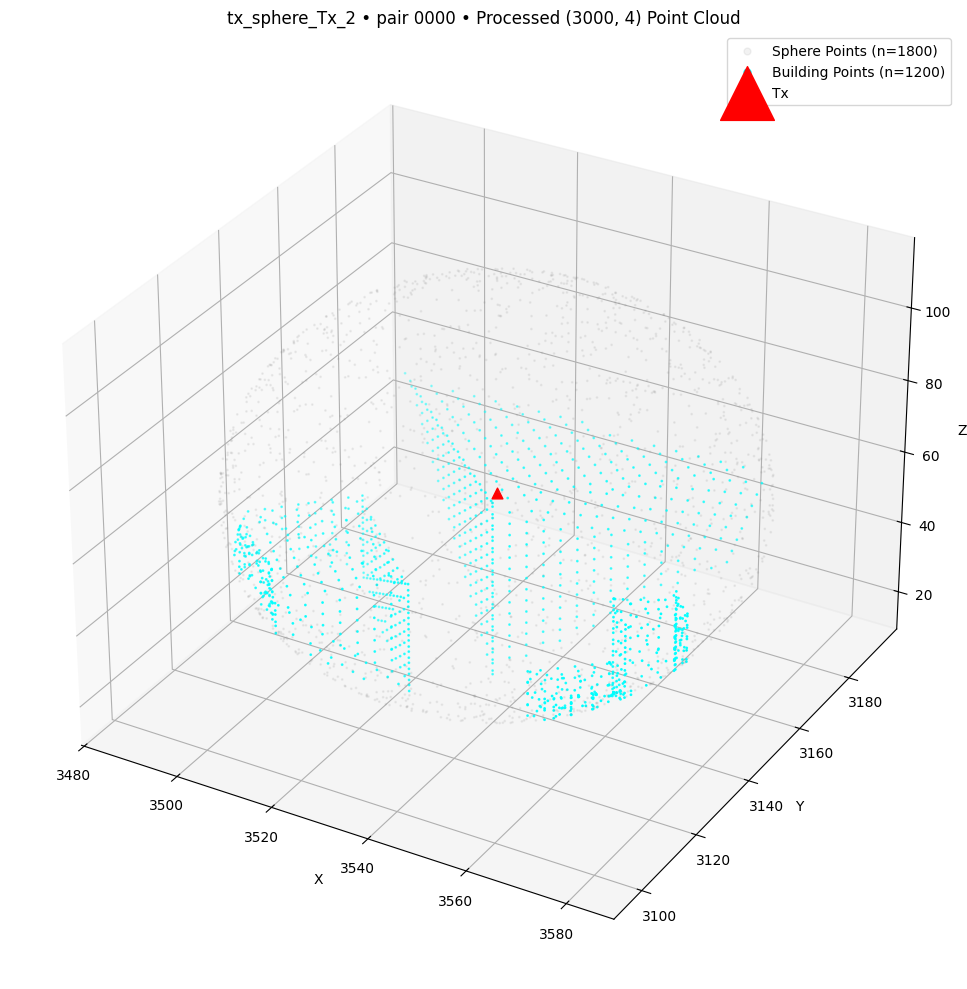

In [5]:
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt # Re-added for plotting

# Point this at any extracted pair folder, e.g.
#   /.../extracted_regions/train/7GHz_Tx_1/
#   /.../extracted_regions/7GHz_Tx_12/
BASE_DIR_FOR_PREPROCESS = Path("/home/mkrishne/PL_competition/extracted_regions/train/tx_sphere_Tx_2/")
PAIR_IDX_FOR_PREPROCESS = 0  # which pair to process

# Define a point DENSITY for random sampling
POINTS_PER_SQUARE_METER = 0.1 # How many points to sample for every 1 sq meter of surface area

# NEW: Define the target fixed size for the point cloud
TARGET_POINTS = 3000

# ---------- I/O helpers ----------
def _npz_path(base_dir: Path, pair_idx: int, tag: str) -> Path:
    return base_dir / f"pair{pair_idx:05d}_{tag}.npz"

def _load_region(base_dir: Path, pair_idx: int, tag: str):
    path = _npz_path(base_dir, pair_idx, tag)
    if not path.exists():
        raise FileNotFoundError(f"Missing file: {path}")
    dat = np.load(path, allow_pickle=True)
    polys = [p for p in dat["polys"] if p is not None and len(p) >= 3]
    meta  = {k: dat[k] for k in dat.files if k != "polys"}
    # be safe about dtypes/shapes
    meta["Tx"] = np.array(meta["Tx"], dtype=float).reshape(-1)
    if "Rx" in meta:
        meta["Rx"] = np.array(meta["Rx"], dtype=float).reshape(-1)
    return polys, meta

# ---------- Point Cloud Sampling Helpers ----------
def _triangulate_polygon(poly):
    """Assumes a convex polygon and creates a triangle fan."""
    if len(poly) < 3:
        return []
    V0 = poly[0]
    triangles = []
    for i in range(1, len(poly) - 1):
        V1 = poly[i]
        V2 = poly[i+1]
        triangles.append((V0, V1, V2))
    return triangles

def _point_in_triangle_2d(pt, v0, v1, v2):
    """
    Checks if a 2D point is inside a 2D triangle.
    Uses the "Sign of Half-Planes" method (robust and fast).
    """
    def sign(p1, p2, p3):
        return (p1[0] - p3[0]) * (p2[1] - p3[1]) - (p2[0] - p3[0]) * (p1[1] - p3[1])
    d1 = sign(pt, v0, v1)
    d2 = sign(pt, v1, v2)
    d3 = sign(pt, v2, v0)
    # Check for floating point inaccuracies near zero
    has_neg = (d1 < -1e-9) or (d2 < -1e-9) or (d3 < -1e-9)
    has_pos = (d1 > 1e-9) or (d2 > 1e-9) or (d3 > 1e-9)
    # Point is inside or on the edge if all signs are the same
    return not (has_neg and has_pos)

def sample_mesh_surface(polys, points_per_sq_meter):
    """
    Samples points from the surface of the mesh using a UNIFORM GRID.
    Total points sampled is proportional to the total surface area.
    """
    all_triangles = []
    total_area = 0.0
    
    # 1. Triangulate all polygons and calculate their total area
    for poly in polys:
        triangles_in_poly = _triangulate_polygon(poly)
        for tri in triangles_in_poly:
            V0, V1, V2 = tri
            area = 0.5 * np.linalg.norm(np.cross(V1 - V0, V2 - V0))
            if area > 1e-9: # Avoid degenerate triangles
                all_triangles.append(tri)
                total_area += area
    if total_area == 0:
        print("No valid triangle area found. Returning empty point cloud.")
        return np.array([]).reshape(0, 3)
        
    # 2. Calculate grid spacing
    grid_step = 1.0 / np.sqrt(points_per_sq_meter)
    points_sampled = []
    
    print(f"Total mesh area: {total_area:.2f} sq m. Sampling with grid step {grid_step:.3f} m.")
    # 3. Loop over all triangles and sample grid points on their surface
    for tri in all_triangles:
        V0, V1, V2 = tri
        
        # 1. Create the 2D orthonormal basis for the triangle's plane
        u_vec = V1 - V0
        v_vec_unscaled = V2 - V0
        
        u_len = np.linalg.norm(u_vec)
        if u_len < 1e-9: continue # Degenerate edge
        
        u_axis = u_vec / u_len
        
        # Get the component of v_vec_unscaled projected onto u_axis
        v_proj_u_scalar = np.dot(v_vec_unscaled, u_axis)
        
        # Get the component of v_vec_unscaled perpendicular to u_axis
        v_vec_perp = v_vec_unscaled - v_proj_u_scalar * u_axis
        
        v_len = np.linalg.norm(v_vec_perp)
        if v_len < 1e-9: continue # Degenerate triangle (collinear vertices)
        
        v_axis = v_vec_perp / v_len
        
        # 2. Define the 2D triangle vertices in this new basis (V0 is origin)
        v0_2d = np.array([0.0, 0.0])
        v1_2d = np.array([u_len, 0.0])
        v2_2d = np.array([v_proj_u_scalar, v_len])
        
        # 3. Find the 2D bounding box of the triangle in this basis
        min_x = min(v0_2d[0], v1_2d[0], v2_2d[0]) - 1e-9
        max_x = max(v0_2d[0], v1_2d[0], v2_2d[0]) + 1e-9
        min_y = min(v0_2d[1], v1_2d[1], v2_2d[1]) - 1e-9
        max_y = max(v0_2d[1], v1_2d[1], v2_2d[1]) + 1e-9
        
        # 4. Determine grid loop range
        x_start = np.floor(min_x / grid_step) * grid_step
        y_start = np.floor(min_y / grid_step) * grid_step
        
        n_steps_x = int(np.ceil((max_x - x_start) / grid_step)) + 1
        n_steps_y = int(np.ceil((max_y - y_start) / grid_step)) + 1
        
        # 5. Loop over grid points in the 2D bounding box
        for i in range(n_steps_x):
            x = x_start + i * grid_step
            for j in range(n_steps_y):
                y = y_start + j * grid_step
                
                pt_2d = np.array([x, y])
                
                # 6. Check if the 2D grid point is inside the 2D triangle
                if _point_in_triangle_2d(pt_2d, v0_2d, v1_2d, v2_2d):
                    # 7. Convert 2D basis point back to 3D and store
                    P_3d = V0 + x * u_axis + y * v_axis
                    points_sampled.append(P_3d)

    if not points_sampled:
        print("No points sampled (grid step might be larger than any triangle).")
        return np.array([]).reshape(0, 3)

    # 8. De-duplicate points
    all_points = np.array(points_sampled)
    precision_decimals = int(np.ceil(-np.log10(grid_step)) + 2)
    unique_points = np.unique(all_points.round(decimals=precision_decimals), axis=0)
    
    print(f"Sampled {unique_points.shape[0]} unique grid points.")
    return unique_points
    
# ---------- NEW HELPER for Sphere Sampling ----------
def _sample_sphere_surface(center, radius, n_points):
    """
    Samples n_points uniformly from the surface of a sphere.
    Uses the "Marsaglia" method for uniform sampling.
    """
    if n_points <= 0:
        return np.array([]).reshape(0, 3)
        
    # Generate points in a 3D standard normal distribution
    vec = np.random.randn(n_points, 3)
    
    # Normalize each vector to get points on a unit sphere
    vec_norm = np.linalg.norm(vec, axis=1, keepdims=True)
    
    # Avoid division by zero for any zero-vectors, though rare
    vec_norm[vec_norm == 0] = 1.0
    vec = vec / vec_norm
    
    # Scale by radius and offset by center
    points = vec * radius + center
    return points

# ---------- NEW Plotting Function ----------
def plot_processed_cloud(output_array, tx_coord, base_dir, pair_idx):
    """
    Plots the final (N, 4) processed point cloud.
    """
    if output_array.shape[0] == 0:
        print("Cannot plot empty point cloud.")
        return

    points_xyz = output_array[:, :3]
    is_building = output_array[:, 3] == 1
    is_sphere = ~is_building
    
    points_building = points_xyz[is_building]
    points_sphere = points_xyz[is_sphere]

    fig = plt.figure(figsize=(12, 10))
    ax = fig.add_subplot(111, projection='3d')

    # Plot sphere points (if any)
    if points_sphere.shape[0] > 0:
        ax.scatter(
            points_sphere[:, 0], points_sphere[:, 1], points_sphere[:, 2],
            s=1, color='gray', alpha=0.1, label=f'Sphere Points (n={points_sphere.shape[0]})'
        )
        
    # Plot building points (if any)
    if points_building.shape[0] > 0:
        ax.scatter(
            points_building[:, 0], points_building[:, 1], points_building[:, 2],
            s=1, color='cyan', label=f'Building Points (n={points_building.shape[0]})'
        )
        
    # Plot the original Tx position
    ax.scatter(tx_coord[0], tx_coord[1], tx_coord[2], s=60, marker='^', label='Tx', color='red')
    
    ax.set_xlabel('X'); ax.set_ylabel('Y'); ax.set_zlabel('Z')
    ax.set_title(f'{base_dir.name} • pair {pair_idx:04d} • Processed (3000, 4) Point Cloud')

    # Set equal aspect ratio
    all_pts_for_plot = np.vstack([points_xyz, tx_coord.reshape(1,3)])
    mins = all_pts_for_plot.min(axis=0); maxs = all_pts_for_plot.max(axis=0)
    
    center = (maxs + mins) / 2.0
    span = maxs - mins
    max_span = np.max(span) * 1.1 
    
    if max_span == 0: # Handle case with only one point
        max_span = 1.0
    
    ax.set_xlim(center[0] - max_span / 2.0, center[0] + max_span / 2.0)
    ax.set_ylim(center[1] - max_span / 2.0, center[1] + max_span / 2.0)
    ax.set_zlim(center[2] - max_span / 2.0, center[2] + max_span / 2.0)

    ax.legend(loc='upper right', markerscale=5)
    plt.tight_layout()
    plt.show()


# ---------- Main Preprocessing Function ----------
def preprocess_and_save(base_dir: Path, pair_idx: int, target_points: int):
    
    print(f"--- Processing pair {pair_idx} in {base_dir.name} ---")
    
    # 1. Load regions (TX sphere only)
    try:
        polys_TX, meta_TX = _load_region(base_dir, pair_idx, "tx_sphere50")
    except FileNotFoundError as e:
        print(e)
        print("Cannot preprocess. Exiting.")
        return

    # 2. Get metadata
    Tx = meta_TX["Tx"]
    if "R" not in meta_TX:
        print("Error: R (sphere radius) not found in metadata.")
        return
    R  = float(meta_TX["R"])  # 50 m

    # 3. Sample building mesh to get initial point cloud
    pc_buildings = sample_mesh_surface(polys_TX, POINTS_PER_SQUARE_METER)
    
    # 4. Normalization steps REMOVED
    # We will use the original coordinates
    pc_buildings_norm = pc_buildings # Use original points
    tx_norm = Tx # Use original Tx
    
    n_building_points = pc_buildings_norm.shape[0]
    print(f"Found {n_building_points} building points.")

    # 5. Apply fixed-size logic
    if n_building_points > target_points:
        # Case 1: Too many points. Randomly sub-sample.
        print(f"Sub-sampling to {target_points} points.")
        indices = np.random.choice(n_building_points, target_points, replace=False)
        
        pc_final = pc_buildings_norm[indices]
        # All points are buildings
        features_final = np.ones((target_points, 1))
        
    elif n_building_points < target_points:
        # Case 2: Too few points. Add sphere points.
        num_to_add = target_points - n_building_points
        print(f"Adding {num_to_add} sphere points.")
        
        # Sample sphere points (in global coordinates)
        pc_sphere = _sample_sphere_surface(Tx, R, num_to_add)
        
        # Use original sphere points (no normalization)
        pc_sphere_norm = pc_sphere
        
        # Combine building and sphere points
        pc_final = np.vstack([pc_buildings_norm, pc_sphere_norm])
        
        # Create corresponding features (1 for building, 0 for sphere)
        features_build = np.ones((n_building_points, 1))
        features_sphere = np.zeros((num_to_add, 1))
        features_final = np.vstack([features_build, features_sphere])
        
    else:
        # Case 3: Exactly the right number of points.
        print(f"Found exactly {target_points} points. No sampling needed.")
        pc_final = pc_buildings_norm
        features_final = np.ones((target_points, 1))

    # 6. Combine into final (N, 4) array
    output_array = np.hstack([pc_final, features_final])
    
    # 7. Save the processed array
    output_filename = base_dir / f"pair{pair_idx:05d}_processed_pc.npy"
    np.save(output_filename, output_array.astype(np.float32)) # Save as float32
    
    print(f"\nSuccessfully saved processed point cloud to:")
    print(f"{output_filename}")
    print(f"Final array shape: {output_array.shape}")
    
    # 8. Optional: Print stats for verification
    if output_array.shape[0] > 0:
        pc_min = output_array[:, :3].min(axis=0)
        pc_max = output_array[:, :3].max(axis=0)
        print("\n=== Final Point Cloud Stats (Original Coords) ===")
        print(f"X: min={pc_min[0]:.3f}, max={pc_max[0]:.3f}")
        print(f"Y: min={pc_min[1]:.3f}, max={pc_max[1]:.3f}")
        print(f"Z: min={pc_min[2]:.3f}, max={pc_max[2]:.3f}")
        print(f"is_building: {int(features_final.sum())} / {target_points} points")
        print("==========================================")
        
    # 9. Plot the final processed cloud
    plot_processed_cloud(output_array, tx_norm, base_dir, pair_idx)


# ---- Run ----
if __name__ == "__main__":
    if not BASE_DIR_FOR_PREPROCESS.exists():
        print(f"Error: Path not found. Please update BASE_DIR_FOR_PREPROCESS in the script.")
        print(f"Current path: {BASE_DIR_FOR_PREPROCESS}")
    else:
        preprocess_and_save(BASE_DIR_FOR_PREPROCESS, PAIR_IDX_FOR_PREPROCESS, TARGET_POINTS)


Total mesh area: 16604.69 sq m. Sampling with grid step 3.162 m.
Sampled 1178 unique grid points.

=== Point Cloud Stats ===
X: min=3431.320, max=3527.750
Y: min=3462.720, max=3549.810
Z: min=0.000, max=43.950



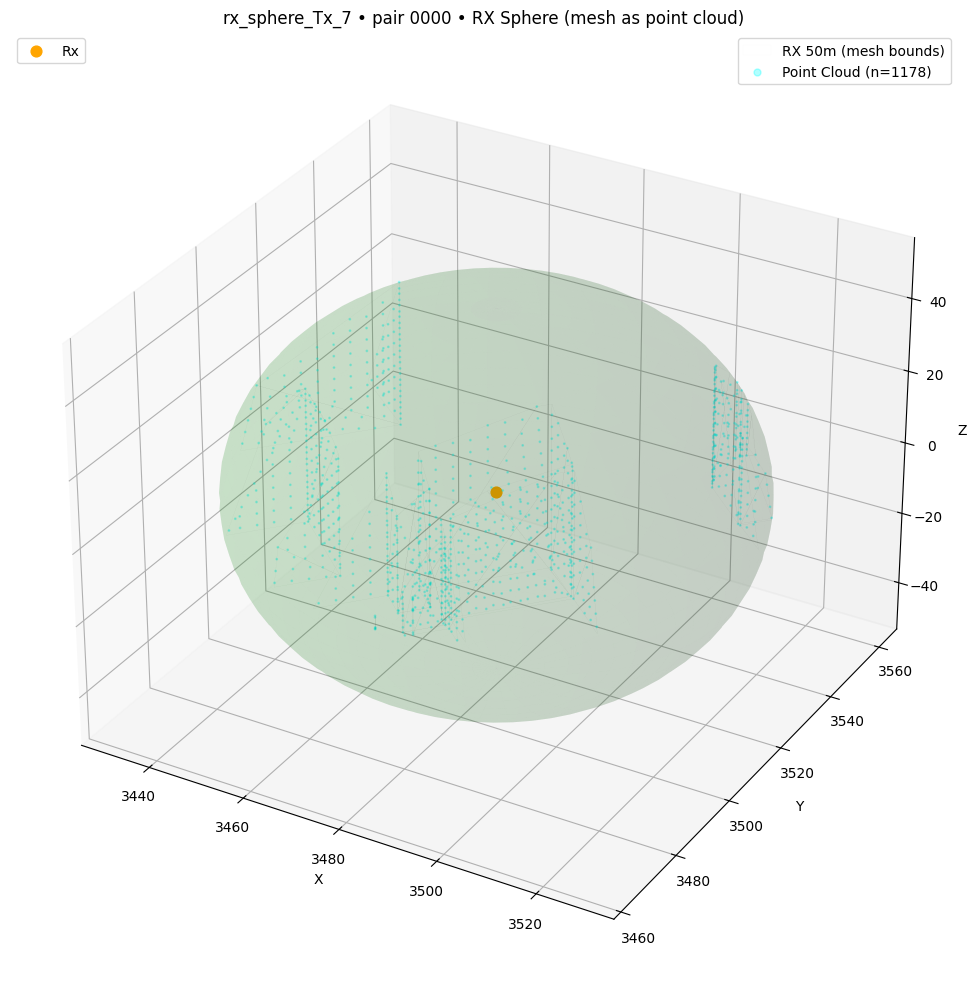

In [6]:
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

# Point this at the base 'train' or 'test' directory
BASE_DIR_FOR_PLOT = Path("/home/mkrishne/PL_competition/extracted_regions/train/")
# Define the specific scene folder to load
SCENE_NAME = "rx_sphere_Tx_7" # This will be combined with the base dir
PAIR_IDX_FOR_PLOT = 0  # which pair to visualize

# Define a point DENSITY for random sampling
POINTS_PER_SQUARE_METER = 0.1 # How many points to sample for every 1 sq meter of surface area

# ---------- I/O helpers ----------
def _npz_path(base_dir: Path, scene: str, pair_idx: int, tag: str) -> Path:
    # MODIFIED: Construct path using base_dir/scene/filename
    return base_dir / scene / f"pair{pair_idx:05d}_{tag}.npz"

def _load_region(base_dir: Path, scene: str, pair_idx: int, tag: str):
    # MODIFIED: Pass 'scene' to _npz_path
    path = _npz_path(base_dir, scene, pair_idx, tag)
    if not path.exists():
        raise FileNotFoundError(f"Missing file: {path}")
    dat = np.load(path, allow_pickle=True)
    polys = [p for p in dat["polys"] if p is not None and len(p) >= 3]
    meta  = {k: dat[k] for k in dat.files if k != "polys"}
    # be safe about dtypes/shapes
    meta["Tx"] = np.array(meta["Tx"], dtype=float).reshape(-1)
    if "Rx" in meta:
        meta["Rx"] = np.array(meta["Rx"], dtype=float).reshape(-1)
    return polys, meta

# ---------- Surfaces ----------
def _sphere_surface(C, R, n_theta=36, n_phi=60):
    theta = np.linspace(0.0, np.pi, n_theta)
    phi   = np.linspace(0.0, 2.0*np.pi, n_phi)
    T, P  = np.meshgrid(theta, phi)
    X = C[0] + R*np.sin(T)*np.cos(P)
    Y = C[1] + R*np.sin(T)*np.sin(P)
    Z = C[2] + R*np.cos(T)
    return X, Y, Z

# Note: _fresnel_ellipsoid_surface is no longer called, but left for completeness
def _fresnel_ellipsoid_surface(T, Tx, Rx, n_theta=48, n_phi=80):
    D = float(np.linalg.norm(Rx - Tx))
    a = T/2.0
    c = D/2.0
    b = np.sqrt(max(a*a - c*c, 0.0))
    center = 0.5*(Tx + Rx)
    theta = np.linspace(0.0, np.pi, n_theta)
    phi   = np.linspace(0.0, 2.0*np.pi, n_phi)
    Tm, Pm = np.meshgrid(theta, phi)
    Xloc = a * np.cos(Tm)
    Yloc = b * np.sin(Tm) * np.cos(Pm)
    Zloc = b * np.sin(Tm) * np.sin(Pm)
    u = (Rx - Tx) / (D + 1e-15)
    tmp = np.array([0.0,0.0,1.0]) if abs(np.dot(u,[0,0,1])) < 0.9 else np.array([0.0,1.0,0.0])
    v = np.cross(u, tmp); v /= (np.linalg.norm(v) + 1e-15)
    w = np.cross(u, v)
    X = center[0] + Xloc*u[0] + Yloc*v[0] + Zloc*w[0]
    Y = center[1] + Xloc*u[1] + Yloc*v[1] + Zloc*w[1]
    Z = center[2] + Xloc*u[2] + Yloc*v[2] + Zloc*w[2]
    return X, Y, Z

# ---------- Point Cloud Sampling Helpers ----------

def _triangulate_polygon(poly):
    """Assumes a convex polygon and creates a triangle fan."""
    if len(poly) < 3:
        return []
    V0 = poly[0]
    triangles = []
    for i in range(1, len(poly) - 1):
        V1 = poly[i]
        V2 = poly[i+1]
        triangles.append((V0, V1, V2))
    return triangles

# --- REVERTED to random sampling helpers ---
# MODIFIED: Reverted to UNIFORM GRID sampling
def _point_in_triangle_2d(pt, v0, v1, v2):
    """
    Checks if a 2D point is inside a 2D triangle.
    Uses the "Sign of Half-Planes" method (robust and fast).
    """
    def sign(p1, p2, p3):
        return (p1[0] - p3[0]) * (p2[1] - p3[1]) - (p2[0] - p3[0]) * (p1[1] - p3[1])

    d1 = sign(pt, v0, v1)
    d2 = sign(pt, v1, v2)
    d3 = sign(pt, v2, v0)

    # Check for floating point inaccuracies near zero
    has_neg = (d1 < -1e-9) or (d2 < -1e-9) or (d3 < -1e-9)
    has_pos = (d1 > 1e-9) or (d2 > 1e-9) or (d3 > 1e-9)

    # Point is inside or on the edge if all signs are the same
    return not (has_neg and has_pos)

def sample_mesh_surface(polys, points_per_sq_meter):
    """
    MODIFIED: Samples points from the surface of the mesh using a UNIFORM GRID.
    Total points sampled is proportional to the total surface area.
    """
    all_triangles = []
    total_area = 0.0
    
    # 1. Triangulate all polygons and calculate their total area
    for poly in polys:
        triangles_in_poly = _triangulate_polygon(poly)
        for tri in triangles_in_poly:
            V0, V1, V2 = tri
            area = 0.5 * np.linalg.norm(np.cross(V1 - V0, V2 - V0))
            if area > 1e-9: # Avoid degenerate triangles
                all_triangles.append(tri)
                total_area += area

    if total_area == 0:
        print("No valid triangle area found. Returning empty point cloud.")
        return np.array([]).reshape(0, 3)

    # --- THIS IS THE NEW GRID LOGIC ---
    if points_per_sq_meter <= 1e-9:
        print(f"Total area {total_area:.2f} sq_m is too small to generate points at {points_per_sq_meter}/sq_m.")
        return np.array([]).reshape(0, 3)
        
    # 2. Calculate grid spacing
    grid_step = 1.0 / np.sqrt(points_per_sq_meter)
    points_sampled = []
    
    print(f"Total mesh area: {total_area:.2f} sq m. Sampling with grid step {grid_step:.3f} m.")

    # 3. Loop over all triangles and sample grid points on their surface
    for tri in all_triangles:
        V0, V1, V2 = tri
        
        # 1. Create the 2D orthonormal basis for the triangle's plane
        u_vec = V1 - V0
        v_vec_unscaled = V2 - V0
        
        u_len = np.linalg.norm(u_vec)
        if u_len < 1e-9: continue # Degenerate edge
        
        u_axis = u_vec / u_len
        
        # Get the component of v_vec_unscaled projected onto u_axis
        v_proj_u_scalar = np.dot(v_vec_unscaled, u_axis)
        
        # Get the component of v_vec_unscaled perpendicular to u_axis
        v_vec_perp = v_vec_unscaled - v_proj_u_scalar * u_axis
        
        v_len = np.linalg.norm(v_vec_perp)
        if v_len < 1e-9: continue # Degenerate triangle (collinear vertices)
        
        v_axis = v_vec_perp / v_len
        
        # 2. Define the 2D triangle vertices in this new basis (V0 is origin)
        v0_2d = np.array([0.0, 0.0])
        v1_2d = np.array([u_len, 0.0])
        # v2's x-coord is its projection onto u_axis, y-coord is its perp. length
        v2_2d = np.array([v_proj_u_scalar, v_len])
        
        # 3. Find the 2D bounding box of the triangle in this basis
        min_x = min(v0_2d[0], v1_2d[0], v2_2d[0]) - 1e-9
        max_x = max(v0_2d[0], v1_2d[0], v2_2d[0]) + 1e-9
        min_y = min(v0_2d[1], v1_2d[1], v2_2d[1]) - 1e-9
        max_y = max(v0_2d[1], v1_2d[1], v2_2d[1]) + 1e-9
        
        # 4. Determine grid loop range
        x_start = np.floor(min_x / grid_step) * grid_step
        y_start = np.floor(min_y / grid_step) * grid_step
        
        n_steps_x = int(np.ceil((max_x - x_start) / grid_step)) + 1
        n_steps_y = int(np.ceil((max_y - y_start) / grid_step)) + 1

        # 5. Loop over grid points in the 2D bounding box
        for i in range(n_steps_x):
            x = x_start + i * grid_step
            for j in range(n_steps_y):
                y = y_start + j * grid_step
                
                pt_2d = np.array([x, y])
                
                # 6. Check if the 2D grid point is inside the 2D triangle
                if _point_in_triangle_2d(pt_2d, v0_2d, v1_2d, v2_2d):
                    # 7. Convert 2D basis point back to 3D and store
                    P_3d = V0 + x * u_axis + y * v_axis
                    points_sampled.append(P_3d)

    if not points_sampled:
        print("No points sampled (grid step might be larger than any triangle).")
        return np.array([]).reshape(0, 3)

    # 8. De-duplicate points (grid sampling creates duplicates on shared edges)
    all_points = np.array(points_sampled)
    
    # Round points to a precision finer than the grid step to merge near-identical points
    # This accounts for floating point errors
    precision_decimals = int(np.ceil(-np.log10(grid_step)) + 2)
    
    unique_points = np.unique(all_points.round(decimals=precision_decimals), axis=0)
    
    print(f"Sampled {unique_points.shape[0]} unique grid points.")

    return unique_points
    # --- END OF NEW GRID LOGIC ---


# ---------- Main plotting ----------
def plot_folder(base_dir: Path, scene: str, pair_idx: int = 0):
    # Load regions (TX sphere only)
    try:
        # MODIFIED: Load rx_sphere50 file using 'scene'
        polys_RX, meta_RX = _load_region(base_dir, scene, pair_idx, "rx_sphere50")
    except FileNotFoundError as e:
        print(e)
        # MODIFIED: Print a more helpful error message
        print(f"Trying to find: {base_dir / scene / f'pair{pair_idx:05d}_rx_sphere50.npz'}")
        print("Cannot plot. Exiting.")
        return

    # Shared metadata
    # MODIFIED: Get Tx, Rx and R (sphere radius)
    # Tx = meta_RX.get("Tx") # No longer need to load Tx for plotting
    Rx = meta_RX.get("Rx")
    
    if Rx is None:
        print("Error: Rx not found in metadata.")
        return
    # if Tx is None: # No longer need this check
    #      print("Error: Tx not found in metadata.")
    #      return
         
    if "R" not in meta_RX:
        print("Error: R (sphere radius) not found in metadata.")
        return
    R  = float(meta_RX["R"])  # 50 m

    # ----- Sample mesh to create point cloud -----
    # MODIFIED: Pass RX Sphere polygons
    point_cloud = sample_mesh_surface(polys_RX, POINTS_PER_SQUARE_METER)
    if point_cloud.shape[0] > 0:
        pc_min = point_cloud.min(axis=0)
        pc_max = point_cloud.max(axis=0)
        print("\n=== Point Cloud Stats ===")
        print(f"X: min={pc_min[0]:.3f}, max={pc_max[0]:.3f}")
        print(f"Y: min={pc_min[1]:.3f}, max={pc_max[1]:.3f}")
        print(f"Z: min={pc_min[2]:.3f}, max={pc_max[2]:.3f}")
        print("========================\n")
    else:
        print("Point cloud is empty. No stats to print.")

    # Surfaces
    # MODIFIED: Generate full sphere surface centered on RX
    Xs_rx, Ys_rx, Zs_rx = _sphere_surface(Rx, R)

    # For aspect ratio
    all_sets = []
    if polys_RX:
        all_sets.append(np.concatenate(polys_RX, axis=0))
    if point_cloud.shape[0] > 0:
        all_sets.append(point_cloud)
        
    all_sets.extend([
        # Tx[None,:], # REMOVED
        Rx[None,:],
        # MODIFIED: Add sphere surface points
        np.c_[Xs_rx.ravel(), Ys_rx.ravel(), Zs_rx.ravel()],
    ])
    
    if not all_sets:
        print("No data to plot (empty clipped region and no surface points).")
        return
        
    all_pts = np.concatenate(all_sets, axis=0)
    mins = all_pts.min(axis=0); maxs = all_pts.max(axis=0)

    # Plot
    fig = plt.figure(figsize=(12,10))
    ax = fig.add_subplot(111, projection='3d')

    # Plot Clipped TX Polygons
    if polys_RX:
        ax.add_collection(Poly3DCollection(
            polys_RX, facecolor=(0.2,0.85,0.2,0.0), edgecolor=(0.1,0.1,0.1,0.05), linewidths=0.1, 
            label='RX 50m (mesh bounds)' # MODIFIED
        ))

    # Plot Full RX Sphere Surface
    ax.plot_surface(Xs_rx, Ys_rx, Zs_rx, alpha=0.1, linewidth=0, antialiased=True, color='green') # MODIFIED

    # ----- Plot Point Cloud -----
    if point_cloud.shape[0] > 0:
        # The label now dynamically shows the number of points, which will vary
        ax.scatter(
            point_cloud[:,0], point_cloud[:,1], point_cloud[:,2], 
            s=1, alpha=0.3, color='cyan', label=f'Point Cloud (n={point_cloud.shape[0]})'
        )
    # ---------------------------------

    # Plot TX Point
    # ax.scatter([Tx[0]],[Tx[1]],[Tx[2]], s=60, marker='^', label='Tx', color='red') # REMOVED
    
    # MODIFIED: Plot RX Point
    ax.scatter([Rx[0]],[Rx[1]],[Rx[2]], s=60, marker='o', label='Rx', color='orange')

    ax.set_xlabel('X'); ax.set_ylabel('Y'); ax.set_zlabel('Z')
    # MODIFIED: Update title to include scene
    ax.set_title(f'{scene} • pair {pair_idx:04d} • RX Sphere (mesh as point cloud)')
    
    # ----- Set equal aspect ratio manually -----
    center = (maxs + mins) / 2.0
    span = maxs - mins
    max_span = np.max(span) * 1.1 
    
    ax.set_xlim(center[0] - max_span / 2.0, center[0] + max_span / 2.0)
    ax.set_ylim(center[1] - max_span / 2.0, center[1] + max_span / 2.0)
    ax.set_zlim(center[2] - max_span / 2.0, center[2] + max_span / 2.0)
        
    # ----- Handle legends separately -----
    handles, labels = ax.get_legend_handles_labels()
    
    rx_handles = [] # Renamed
    rx_labels = [] # Renamed
    other_handles = []
    other_labels = []
    
    for h, l in zip(handles, labels):
        # MODIFIED: Separate Rx only
        if l == 'Rx':
            rx_handles.append(h)
            rx_labels.append(l)
        else:
            other_handles.append(h)
            other_labels.append(l)

    legend1 = ax.legend(other_handles, other_labels, loc='upper right', markerscale=5)
    
    if rx_handles:
        ax.add_artist(legend1) 
        ax.legend(rx_handles, rx_labels, loc='upper left', markerscale=1)
    
    plt.tight_layout(); plt.show()

# ---- Run ----
# Make sure to update BASE_DIR_FOR_PLOT to point to your data
if __name__ == "__main__":
    # MODIFIED: Check full path
    full_path_check = BASE_DIR_FOR_PLOT / SCENE_NAME
    if not full_path_check.exists():
        print(f"Error: Path not found. Please update BASE_DIR_FOR_PLOT and SCENE_NAME in the script.")
        print(f"Current path: {full_path_check}")
    else:
        # MODIFIED: Pass scene to plot_folder
        plot_folder(BASE_DIR_FOR_PLOT, SCENE_NAME, PAIR_IDX_FOR_PLOT)

--- Processing pair 0 in rx_sphere_Tx_1 ---
No valid triangle area found. Returning empty point cloud.
Found 0 building points.
Adding 3000 sphere points.

Successfully saved processed point cloud to:
/home/mkrishne/PL_competition/extracted_regions/train/rx_sphere_Tx_1/pair00000_processed_pc_rx.npy
Final array shape: (3000, 4)

=== Final Point Cloud Stats (Original Coords) ===
X: min=3795.318, max=3895.285
Y: min=2167.545, max=2267.489
Z: min=-48.489, max=51.432
is_building: 0 / 3000 points

=== First 5 Points (X, Y, Z, is_building) ===
[[3853.98846214 2266.04525928   -6.75139273    0.        ]
 [3805.80325495 2235.41747022  -23.35928029    0.        ]
 [3814.05483333 2248.52625137  -22.17129064    0.        ]
 [3887.9735948  2221.64778872   27.24542366    0.        ]
 [3871.100957   2257.08093876   17.88001136    0.        ]]

=== Last 5 Points (X, Y, Z, is_building) ===
[[3879.0412516  2192.22061982   28.3946882     0.        ]
 [3805.39321423 2245.71758895   11.99849026    0.       

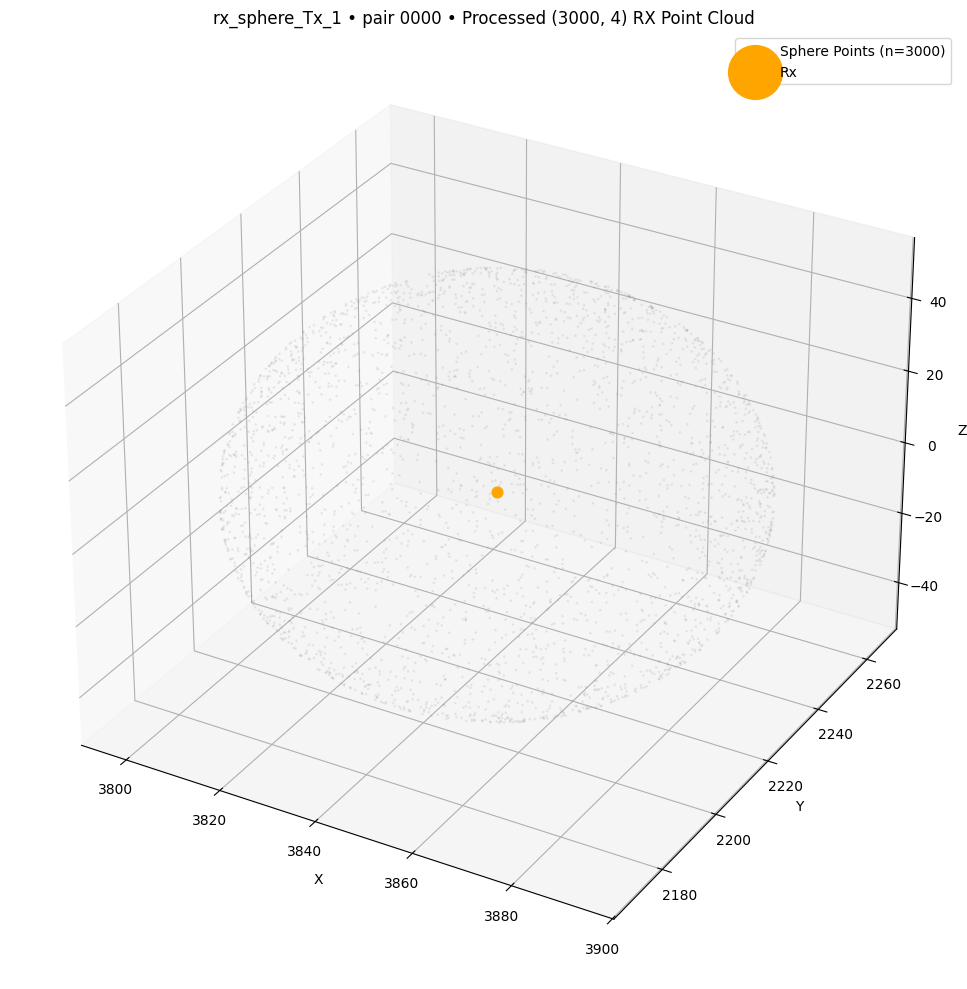

In [7]:
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt # Re-added for plotting

# Point this at the base 'train' or 'test' directory
BASE_DIR_FOR_PREPROCESS = Path("/home/mkrishne/PL_competition/extracted_regions/train/")
# Define the specific scene folder to load
SCENE_NAME = "rx_sphere_Tx_1" # This will be combined with the base dir
PAIR_IDX_FOR_PREPROCESS = 0  # which pair to process

# Define a point DENSITY for random sampling
POINTS_PER_SQUARE_METER = 0.1 # How many points to sample for every 1 sq meter of surface area

# NEW: Define the target fixed size for the point cloud
TARGET_POINTS = 3000

# ---------- I/O helpers ----------
def _npz_path(base_dir: Path, scene: str, pair_idx: int, tag: str) -> Path:
    # MODIFIED: Construct path using base_dir/scene/filename
    return base_dir / scene / f"pair{pair_idx:05d}_{tag}.npz"

def _load_region(base_dir: Path, scene: str, pair_idx: int, tag: str):
    # MODIFIED: Pass 'scene' to _npz_path
    path = _npz_path(base_dir, scene, pair_idx, tag)
    if not path.exists():
        raise FileNotFoundError(f"Missing file: {path}")
    dat = np.load(path, allow_pickle=True)
    polys = [p for p in dat["polys"] if p is not None and len(p) >= 3]
    meta  = {k: dat[k] for k in dat.files if k != "polys"}
    # be safe about dtypes/shapes
    meta["Tx"] = np.array(meta["Tx"], dtype=float).reshape(-1)
    if "Rx" in meta:
        meta["Rx"] = np.array(meta["Rx"], dtype=float).reshape(-1)
    return polys, meta

# ---------- Point Cloud Sampling Helpers ----------
def _triangulate_polygon(poly):
    """Assumes a convex polygon and creates a triangle fan."""
    if len(poly) < 3:
        return []
    V0 = poly[0]
    triangles = []
    for i in range(1, len(poly) - 1):
        V1 = poly[i]
        V2 = poly[i+1]
        triangles.append((V0, V1, V2))
    return triangles

def _point_in_triangle_2d(pt, v0, v1, v2):
    """
    Checks if a 2D point is inside a 2D triangle.
    Uses the "Sign of Half-Planes" method (robust and fast).
    """
    def sign(p1, p2, p3):
        return (p1[0] - p3[0]) * (p2[1] - p3[1]) - (p2[0] - p3[0]) * (p1[1] - p3[1])
    d1 = sign(pt, v0, v1)
    d2 = sign(pt, v1, v2)
    d3 = sign(pt, v2, v0)
    # Check for floating point inaccuracies near zero
    has_neg = (d1 < -1e-9) or (d2 < -1e-9) or (d3 < -1e-9)
    has_pos = (d1 > 1e-9) or (d2 > 1e-9) or (d3 > 1e-9)
    # Point is inside or on the edge if all signs are the same
    return not (has_neg and has_pos)

def sample_mesh_surface(polys, points_per_sq_meter):
    """
    Samples points from the surface of the mesh using a UNIFORM GRID.
    Total points sampled is proportional to the total surface area.
    """
    all_triangles = []
    total_area = 0.0
    
    # 1. Triangulate all polygons and calculate their total area
    for poly in polys:
        triangles_in_poly = _triangulate_polygon(poly)
        for tri in triangles_in_poly:
            V0, V1, V2 = tri
            area = 0.5 * np.linalg.norm(np.cross(V1 - V0, V2 - V0))
            if area > 1e-9: # Avoid degenerate triangles
                all_triangles.append(tri)
                total_area += area
    if total_area == 0:
        print("No valid triangle area found. Returning empty point cloud.")
        return np.array([]).reshape(0, 3)
        
    # 2. Calculate grid spacing
    grid_step = 1.0 / np.sqrt(points_per_sq_meter)
    points_sampled = []
    
    print(f"Total mesh area: {total_area:.2f} sq m. Sampling with grid step {grid_step:.3f} m.")
    # 3. Loop over all triangles and sample grid points on their surface
    for tri in all_triangles:
        V0, V1, V2 = tri
        
        # 1. Create the 2D orthonormal basis for the triangle's plane
        u_vec = V1 - V0
        v_vec_unscaled = V2 - V0
        
        u_len = np.linalg.norm(u_vec)
        if u_len < 1e-9: continue # Degenerate edge
        
        u_axis = u_vec / u_len
        
        # Get the component of v_vec_unscaled projected onto u_axis
        v_proj_u_scalar = np.dot(v_vec_unscaled, u_axis)
        
        # Get the component of v_vec_unscaled perpendicular to u_axis
        v_vec_perp = v_vec_unscaled - v_proj_u_scalar * u_axis
        
        v_len = np.linalg.norm(v_vec_perp)
        if v_len < 1e-9: continue # Degenerate triangle (collinear vertices)
        
        v_axis = v_vec_perp / v_len
        
        # 2. Define the 2D triangle vertices in this new basis (V0 is origin)
        v0_2d = np.array([0.0, 0.0])
        v1_2d = np.array([u_len, 0.0])
        v2_2d = np.array([v_proj_u_scalar, v_len])
        
        # 3. Find the 2D bounding box of the triangle in this basis
        min_x = min(v0_2d[0], v1_2d[0], v2_2d[0]) - 1e-9
        max_x = max(v0_2d[0], v1_2d[0], v2_2d[0]) + 1e-9
        min_y = min(v0_2d[1], v1_2d[1], v2_2d[1]) - 1e-9
        max_y = max(v0_2d[1], v1_2d[1], v2_2d[1]) + 1e-9
        
        # 4. Determine grid loop range
        x_start = np.floor(min_x / grid_step) * grid_step
        y_start = np.floor(min_y / grid_step) * grid_step
        
        n_steps_x = int(np.ceil((max_x - x_start) / grid_step)) + 1
        n_steps_y = int(np.ceil((max_y - y_start) / grid_step)) + 1
        
        # 5. Loop over grid points in the 2D bounding box
        for i in range(n_steps_x):
            x = x_start + i * grid_step
            for j in range(n_steps_y):
                y = y_start + j * grid_step
                
                pt_2d = np.array([x, y])
                
                # 6. Check if the 2D grid point is inside the 2D triangle
                if _point_in_triangle_2d(pt_2d, v0_2d, v1_2d, v2_2d):
                    # 7. Convert 2D basis point back to 3D and store
                    P_3d = V0 + x * u_axis + y * v_axis
                    points_sampled.append(P_3d)

    if not points_sampled:
        print("No points sampled (grid step might be larger than any triangle).")
        return np.array([]).reshape(0, 3)

    # 8. De-duplicate points
    all_points = np.array(points_sampled)
    precision_decimals = int(np.ceil(-np.log10(grid_step)) + 2)
    unique_points = np.unique(all_points.round(decimals=precision_decimals), axis=0)
    
    print(f"Sampled {unique_points.shape[0]} unique grid points.")
    return unique_points
    
# ---------- NEW HELPER for Sphere Sampling ----------
def _sample_sphere_surface(center, radius, n_points):
    """
    Samples n_points uniformly from the surface of a sphere.
    Uses the "Marsaglia" method for uniform sampling.
    """
    if n_points <= 0:
        return np.array([]).reshape(0, 3)
        
    # Generate points in a 3D standard normal distribution
    vec = np.random.randn(n_points, 3)
    
    # Normalize each vector to get points on a unit sphere
    vec_norm = np.linalg.norm(vec, axis=1, keepdims=True)
    
    # Avoid division by zero for any zero-vectors, though rare
    vec_norm[vec_norm == 0] = 1.0
    vec = vec / vec_norm
    
    # Scale by radius and offset by center
    points = vec * radius + center
    return points

# ---------- NEW Plotting Function ----------
def plot_processed_cloud(output_array, rx_coord, base_dir, pair_idx):
    """
    Plots the final (N, 4) processed point cloud.
    """
    if output_array.shape[0] == 0:
        print("Cannot plot empty point cloud.")
        return

    points_xyz = output_array[:, :3]
    is_building = output_array[:, 3] == 1
    is_sphere = ~is_building
    
    points_building = points_xyz[is_building]
    points_sphere = points_xyz[is_sphere]

    fig = plt.figure(figsize=(12, 10))
    ax = fig.add_subplot(111, projection='3d')

    # Plot sphere points (if any)
    if points_sphere.shape[0] > 0:
        ax.scatter(
            points_sphere[:, 0], points_sphere[:, 1], points_sphere[:, 2],
            s=1, color='gray', alpha=0.1, label=f'Sphere Points (n={points_sphere.shape[0]})'
        )
        
    # Plot building points (if any)
    if points_building.shape[0] > 0:
        ax.scatter(
            points_building[:, 0], points_building[:, 1], points_building[:, 2],
            s=1, color='cyan', label=f'Building Points (n={points_building.shape[0]})'
        )
        
    # Plot the original Rx position
    ax.scatter(rx_coord[0], rx_coord[1], rx_coord[2], s=60, marker='o', label='Rx', color='orange')
    
    ax.set_xlabel('X'); ax.set_ylabel('Y'); ax.set_zlabel('Z')
    ax.set_title(f'{base_dir.name} • pair {pair_idx:04d} • Processed (3000, 4) RX Point Cloud')

    # Set equal aspect ratio
    all_pts_for_plot = np.vstack([points_xyz, rx_coord.reshape(1,3)])
    mins = all_pts_for_plot.min(axis=0); maxs = all_pts_for_plot.max(axis=0)
    
    center = (maxs + mins) / 2.0
    span = maxs - mins
    max_span = np.max(span) * 1.1 
    
    if max_span == 0: # Handle case with only one point
        max_span = 1.0
    
    ax.set_xlim(center[0] - max_span / 2.0, center[0] + max_span / 2.0)
    ax.set_ylim(center[1] - max_span / 2.0, center[1] + max_span / 2.0)
    ax.set_zlim(center[2] - max_span / 2.0, center[2] + max_span / 2.0)

    ax.legend(loc='upper right', markerscale=5)
    plt.tight_layout()
    plt.show()


# ---------- Main Preprocessing Function ----------
def preprocess_and_save(base_dir: Path, scene: str, pair_idx: int, target_points: int):
    
    print(f"--- Processing pair {pair_idx} in {scene} ---")
    
    # 1. Load regions (RX sphere only)
    try:
        polys_RX, meta_RX = _load_region(base_dir, scene, pair_idx, "rx_sphere50")
    except FileNotFoundError as e:
        print(e)
        print(f"Trying to find: {base_dir / scene / f'pair{pair_idx:05d}_rx_sphere50.npz'}")
        print("Cannot preprocess. Exiting.")
        return

    # 2. Get metadata
    if "Rx" not in meta_RX:
        print("Error: Rx not found in metadata.")
        return
    Rx = meta_RX["Rx"]
    
    if "R" not in meta_RX:
        print("Error: R (sphere radius) not found in metadata.")
        return
    R  = float(meta_RX["R"])  # 50 m

    # 3. Sample building mesh to get initial point cloud
    pc_buildings = sample_mesh_surface(polys_RX, POINTS_PER_SQUARE_METER)
    
    # 4. Normalization steps REMOVED
    # We will use the original coordinates
    pc_buildings_norm = pc_buildings # Use original points
    
    n_building_points = pc_buildings_norm.shape[0]
    print(f"Found {n_building_points} building points.")

    # 5. Apply fixed-size logic
    if n_building_points > target_points:
        # Case 1: Too many points. Randomly sub-sample.
        print(f"Sub-sampling to {target_points} points.")
        indices = np.random.choice(n_building_points, target_points, replace=False)
        
        pc_final = pc_buildings_norm[indices]
        # All points are buildings
        features_final = np.ones((target_points, 1))
        
    elif n_building_points < target_points:
        # Case 2: Too few points. Add sphere points.
        num_to_add = target_points - n_building_points
        print(f"Adding {num_to_add} sphere points.")
        
        # Sample sphere points (in global coordinates)
        pc_sphere = _sample_sphere_surface(Rx, R, num_to_add) # Use Rx as center
        
        # Use original sphere points (no normalization)
        pc_sphere_norm = pc_sphere
        
        # Combine building and sphere points
        pc_final = np.vstack([pc_buildings_norm, pc_sphere_norm])
        
        # Create corresponding features (1 for building, 0 for sphere)
        features_build = np.ones((n_building_points, 1))
        features_sphere = np.zeros((num_to_add, 1))
        features_final = np.vstack([features_build, features_sphere])
        
    else:
        # Case 3: Exactly the right number of points.
        print(f"Found exactly {target_points} points. No sampling needed.")
        pc_final = pc_buildings_norm
        features_final = np.ones((target_points, 1))

    # 6. Combine into final (N, 4) array
    output_array = np.hstack([pc_final, features_final])
    
    # 7. Save the processed array
    output_filename = base_dir / scene / f"pair{pair_idx:05d}_processed_pc_rx.npy" # MODIFIED filename
    np.save(output_filename, output_array.astype(np.float32)) # Save as float32
    
    print(f"\nSuccessfully saved processed point cloud to:")
    print(f"{output_filename}")
    print(f"Final array shape: {output_array.shape}")
    
    # 8. Optional: Print stats for verification
    if output_array.shape[0] > 0:
        pc_min = output_array[:, :3].min(axis=0)
        pc_max = output_array[:, :3].max(axis=0)
        print("\n=== Final Point Cloud Stats (Original Coords) ===")
        print(f"X: min={pc_min[0]:.3f}, max={pc_max[0]:.3f}")
        print(f"Y: min={pc_min[1]:.3f}, max={pc_max[1]:.3f}")
        print(f"Z: min={pc_min[2]:.3f}, max={pc_max[2]:.3f}")
        print(f"is_building: {int(features_final.sum())} / {target_points} points")
        print("==========================================")
        
        # ADDED PRINT STATEMENTS
        print("\n=== First 5 Points (X, Y, Z, is_building) ===")
        print(output_array[:5])
        print("\n=== Last 5 Points (X, Y, Z, is_building) ===")
        print(output_array[-5:])
        print("==========================================\n")
        
    # 9. Plot the final processed cloud
    plot_processed_cloud(output_array, Rx, base_dir / scene, pair_idx)


# ---- Run ----
if __name__ == "__main__":
    full_path_check = BASE_DIR_FOR_PREPROCESS / SCENE_NAME
    if not full_path_check.exists():
        print(f"Error: Path not found. Please update BASE_DIR_FOR_PREPROCESS and SCENE_NAME in the script.")
        print(f"Current path: {full_path_check}")
    else:
        preprocess_and_save(BASE_DIR_FOR_PREPROCESS, SCENE_NAME, PAIR_IDX_FOR_PREPROCESS, TARGET_POINTS)

No valid triangle area found. Returning empty point cloud.


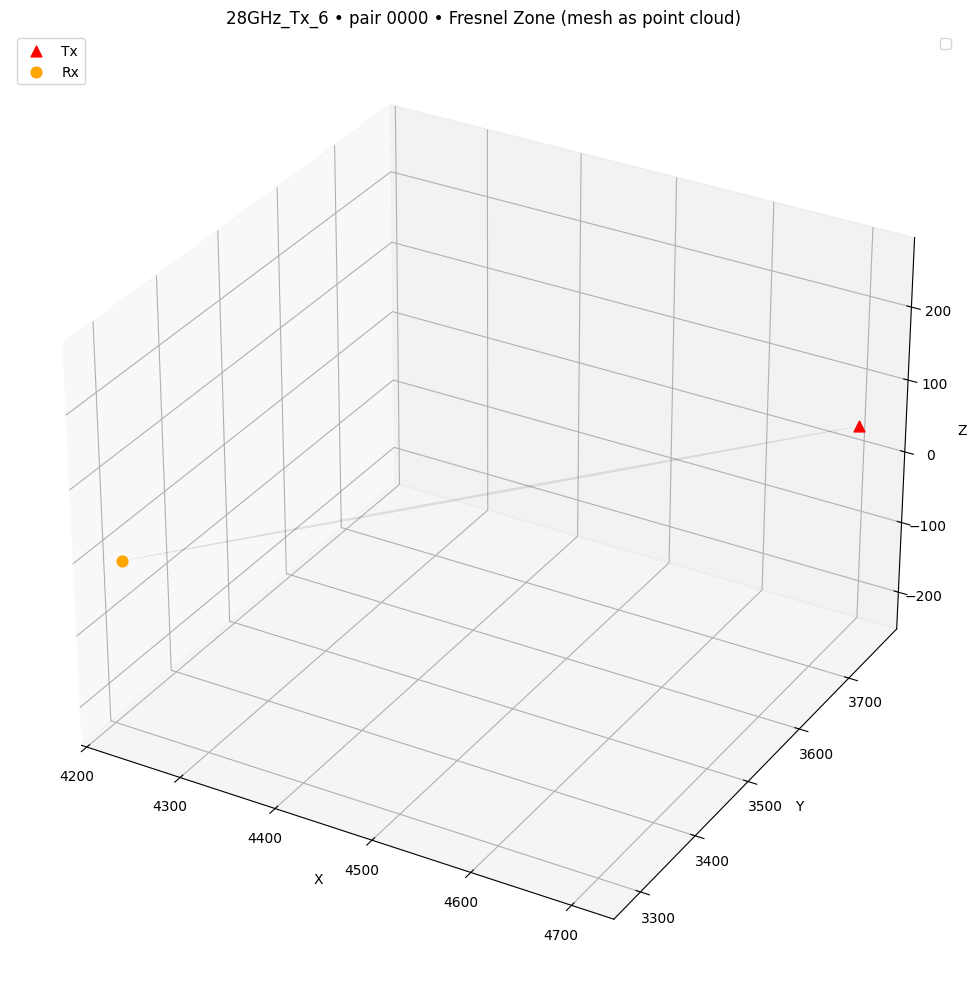

In [8]:
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

# Point this at any extracted pair folder, e.g.
#   /.../extracted_regions/train/7GHz_Tx_1/
#   /.../extracted_regions/7GHz_Tx_12/
# MODIFIED: Pointed to the 800MHz directory
BASE_DIR_FOR_PLOT = Path("/home/mkrishne/PL_competition/extracted_regions/train/28GHz_Tx_6/")
PAIR_IDX_FOR_PLOT = 0  # which pair to visualize

# NEW: Define a point DENSITY, not a fixed total number
POINTS_PER_SQUARE_METER = 0.1 # How many points to sample for every 1 sq meter of surface area

# ---------- I/O helpers ----------
def _npz_path(base_dir: Path, pair_idx: int, tag: str) -> Path:
    return base_dir / f"pair{pair_idx:05d}_{tag}.npz"

def _load_region(base_dir: Path, pair_idx: int, tag: str):
    path = _npz_path(base_dir, pair_idx, tag)
    if not path.exists():
        raise FileNotFoundError(f"Missing file: {path}")
    dat = np.load(path, allow_pickle=True)
    polys = [p for p in dat["polys"] if p is not None and len(p) >= 3]
    meta  = {k: dat[k] for k in dat.files if k != "polys"}
    # be safe about dtypes/shapes
    meta["Tx"] = np.array(meta["Tx"], dtype=float).reshape(-1)
    # MODIFIED: Load Rx if it exists
    if "Rx" in meta:
        meta["Rx"] = np.array(meta["Rx"], dtype=float).reshape(-1)
    return polys, meta

# ---------- Surfaces ----------
def _sphere_surface(C, R, n_theta=36, n_phi=60):
    theta = np.linspace(0.0, np.pi, n_theta)
    phi   = np.linspace(0.0, 2.0*np.pi, n_phi)
    T, P  = np.meshgrid(theta, phi)
    X = C[0] + R*np.sin(T)*np.cos(P)
    Y = C[1] + R*np.sin(T)*np.sin(P)
    Z = C[2] + R*np.cos(T)
    return X, Y, Z

# Note: _fresnel_ellipsoid_surface is no longer called, but left for completeness
def _fresnel_ellipsoid_surface(T, Tx, Rx, n_theta=48, n_phi=80):
    D = float(np.linalg.norm(Rx - Tx))
    a = T/2.0
    c = D/2.0
    b = np.sqrt(max(a*a - c*c, 0.0))
    center = 0.5*(Tx + Rx)
    theta = np.linspace(0.0, np.pi, n_theta)
    phi   = np.linspace(0.0, 2.0*np.pi, n_phi)
    Tm, Pm = np.meshgrid(theta, phi)
    Xloc = a * np.cos(Tm)
    Yloc = b * np.sin(Tm) * np.cos(Pm)
    Zloc = b * np.sin(Tm) * np.sin(Pm)
    u = (Rx - Tx) / (D + 1e-15)
    tmp = np.array([0.0,0.0,1.0]) if abs(np.dot(u,[0,0,1])) < 0.9 else np.array([0.0,1.0,0.0])
    v = np.cross(u, tmp); v /= (np.linalg.norm(v) + 1e-15)
    w = np.cross(u, v)
    X = center[0] + Xloc*u[0] + Yloc*v[0] + Zloc*w[0]
    Y = center[1] + Xloc*u[1] + Yloc*v[1] + Zloc*w[1]
    Z = center[2] + Xloc*u[2] + Yloc*v[2] + Zloc*w[2]
    return X, Y, Z

# ---------- Point Cloud Sampling Helpers ----------

def _triangulate_polygon(poly):
    """Assumes a convex polygon and creates a triangle fan."""
    if len(poly) < 3:
        return []
    V0 = poly[0]
    triangles = []
    for i in range(1, len(poly) - 1):
        V1 = poly[i]
        V2 = poly[i+1]
        triangles.append((V0, V1, V2))
    return triangles

def sample_mesh_surface(polys, points_per_sq_meter):
    """
    Samples points from the surface of the mesh defined by polys.
    Total points sampled is proportional to the total surface area.
    """
    all_triangles = []
    triangle_areas = []
    total_area = 0.0
    
    # 1. Triangulate all polygons and calculate their total area
    for poly in polys:
        triangles_in_poly = _triangulate_polygon(poly)
        for tri in triangles_in_poly:
            V0, V1, V2 = tri
            # Area = 0.5 * | (V1-V0) x (V2-V0) |
            area = 0.5 * np.linalg.norm(np.cross(V1 - V0, V2 - V0))
            if area > 1e-9: # Avoid degenerate triangles
                all_triangles.append(tri)
                triangle_areas.append(area)
                total_area += area

    if total_area == 0:
        print("No valid triangle area found. Returning empty point cloud.")
        return np.array([]).reshape(0, 3)

    # --- THIS IS THE NEW LOGIC ---
    # 2. Calculate total points based on area and density
    total_points = int(np.round(total_area * points_per_sq_meter))
    
    if total_points == 0:
        print(f"Total area {total_area:.2f} sq_m is too small to generate points at {points_per_sq_meter}/sq_m.")
        return np.array([]).reshape(0, 3)

    print(f"Total mesh area: {total_area:.2f} sq m. Sampling {total_points} points ({points_per_sq_meter}/sq m)")
    # --- END OF NEW LOGIC ---

    # 3. Sample points from each triangle based on its area
    points_sampled = []
    num_triangles = len(all_triangles)
    
    # Distribute points based on area
    triangle_areas = np.array(triangle_areas)
    # This calculation remains the same, using the new 'total_points'
    points_per_triangle = np.round(total_points * (triangle_areas / total_area)).astype(int)
    
    # Adjust for rounding errors to ensure exact total_points
    diff = total_points - points_per_triangle.sum()
    if diff != 0:
        # Add/remove points from largest triangles
        indices_to_adjust = np.argsort(triangle_areas)[-abs(diff):]
        points_per_triangle[indices_to_adjust] += np.sign(diff)

    for i in range(num_triangles):
        num_points_for_this_tri = points_per_triangle[i]
        if num_points_for_this_tri == 0:
            continue
            
        V0, V1, V2 = all_triangles[i]
        
        # Uniform sampling within a triangle
        r1 = np.random.rand(num_points_for_this_tri)
        r2 = np.random.rand(num_points_for_this_tri)
        
        sqrt_r1 = np.sqrt(r1).reshape(-1, 1)
        r2 = r2.reshape(-1, 1)
        
        u = (1.0 - sqrt_r1)
        v = sqrt_r1 * (1.0 - r2)
        w = sqrt_r1 * r2
        
        points_on_tri = u * V0 + v * V1 + w * V2
        points_sampled.append(points_on_tri)

    if not points_sampled:
        print("No points sampled (this should be rare if total_points > 0).")
        return np.array([]).reshape(0, 3)

    return np.concatenate(points_sampled, axis=0)

# ---------- Main plotting ----------
def plot_folder(base_dir: Path, pair_idx: int = 0):
    # Load regions (TX sphere only)
    try:
        # MODIFIED: Load fresnel1 file (assuming this is the tag)
        polys_FN, meta_FN = _load_region(base_dir, pair_idx, "fresnel1")
    except FileNotFoundError as e:
        print(e)
        print("Cannot plot. Exiting.")
        return

    # Shared metadata
    # MODIFIED: Get Tx, Rx, and T (ellipsoid parameter) from metadata
    Tx = meta_FN["Tx"]
    if "Rx" not in meta_FN:
        print("Error: Rx coordinate not found in metadata. Cannot plot Fresnel zone.")
        return
    if "T" not in meta_FN:
        # 'T' is the parameter for _fresnel_ellipsoid_surface
        print("Error: T-parameter (ellipsoid thickness) not found in metadata. Cannot plot Fresnel zone.")
        return
    Rx = meta_FN["Rx"]
    T  = float(meta_FN["T"])

    # ----- Sample mesh to create point cloud -----
    # MODIFIED: Pass Fresnel polygons
    point_cloud = sample_mesh_surface(polys_FN, POINTS_PER_SQUARE_METER)
    
    # Surfaces
    # MODIFIED: Generate full Fresnel ellipsoid surface
    Xs_fn, Ys_fn, Zs_fn = _fresnel_ellipsoid_surface(T, Tx, Rx)

    # For aspect ratio
    all_sets = []
    if polys_FN:  # MODIFIED
        all_sets.append(np.concatenate(polys_FN, axis=0)) # MODIFIED
    if point_cloud.shape[0] > 0:
        all_sets.append(point_cloud)
        
    all_sets.extend([
        Tx[None,:],
        Rx[None,:], # MODIFIED: Add Rx
        np.c_[Xs_fn.ravel(), Ys_fn.ravel(), Zs_fn.ravel()], # MODIFIED
    ])
    
    if not all_sets:
        print("No data to plot (empty clipped region and no surface points).")
        return
        
    all_pts = np.concatenate(all_sets, axis=0)
    mins = all_pts.min(axis=0); maxs = all_pts.max(axis=0)

    # Plot
    fig = plt.figure(figsize=(12,10))
    ax = fig.add_subplot(111, projection='3d')

    # Plot Clipped TX Polygons
    if polys_FN: # MODIFIED
        ax.add_collection(Poly3DCollection(
            polys_FN, facecolor=(0.2,0.2,0.85,0.0), edgecolor=(0.1,0.1,0.1,0.05), linewidths=0.1, 
            label='Fresnel 1 (mesh bounds)' # MODIFIED
        ))

    # Plot Full Fresnel Ellipsoid Surface
    ax.plot_surface(Xs_fn, Ys_fn, Zs_fn, alpha=0.05, linewidth=0, antialiased=True, color='green')

    # ----- Plot Point Cloud -----
    if point_cloud.shape[0] > 0:
        # The label now dynamically shows the number of points, which will vary
        ax.scatter(
            point_cloud[:,0], point_cloud[:,1], point_cloud[:,2], 
            s=1, alpha=0.3, color='cyan', label=f'Point Cloud (n={point_cloud.shape[0]})'
        )
    # ---------------------------------

    # Plot TX Point
    ax.scatter([Tx[0]],[Tx[1]],[Tx[2]], s=60, marker='^', label='Tx', color='red')
    
    # MODIFIED: Plot RX Point
    ax.scatter([Rx[0]],[Rx[1]],[Rx[2]], s=60, marker='o', label='Rx', color='orange')

    ax.set_xlabel('X'); ax.set_ylabel('Y'); ax.set_zlabel('Z')
    # MODIFIED: Update title
    ax.set_title(f'{base_dir.name} • pair {pair_idx:04d} • Fresnel Zone (mesh as point cloud)')
    
    # ----- Set equal aspect ratio manually -----
    center = (maxs + mins) / 2.0
    span = maxs - mins
    max_span = np.max(span) * 1.1 
    
    ax.set_xlim(center[0] - max_span / 2.0, center[0] + max_span / 2.0)
    ax.set_ylim(center[1] - max_span / 2.0, center[1] + max_span / 2.0)
    ax.set_zlim(center[2] - max_span / 2.0, center[2] + max_span / 2.0)
        
    # ----- Handle legends separately -----
    handles, labels = ax.get_legend_handles_labels()
    
    tx_handles = []
    tx_labels = []
    other_handles = []
    other_labels = []
    
    for h, l in zip(handles, labels):
        # MODIFIED: Separate Tx and Rx
        if l == 'Tx' or l == 'Rx':
            tx_handles.append(h)
            tx_labels.append(l)
        else:
            other_handles.append(h)
            other_labels.append(l)

    legend1 = ax.legend(other_handles, other_labels, loc='upper right', markerscale=5)
    
    if tx_handles:
        ax.add_artist(legend1) 
        ax.legend(tx_handles, tx_labels, loc='upper left', markerscale=1)
    
    plt.tight_layout(); plt.show()

# ---- Run ----
# Make sure to update BASE_DIR_FOR_PLOT to point to your data
if __name__ == "__main__":
    if not BASE_DIR_FOR_PLOT.exists():
        print(f"Error: Path not found. Please update BASE_DIR_FOR_PLOT in the script.")
        print(f"Current path: {BASE_DIR_FOR_PLOT}")
    else:
        plot_folder(BASE_DIR_FOR_PLOT, PAIR_IDX_FOR_PLOT)



--- Processing pair 0 in 28GHz_Tx_6 ---
Total mesh area: 42.75 sq m. Sampling with grid step 3.162 m.
Sampled 28 unique grid points.
Found 28 Fresnel points.
Adding 972 points from ellipsoid surface.

Successfully saved processed point cloud to:
/home/mkrishne/PL_competition/extracted_regions/train/28GHz_Tx_6/pair00000_processed_pc_fresnel.npy
Final array shape: (1000, 4)

=== Final Point Cloud Stats (Original Coords) ===
X: min=4230.543, max=4705.260
Y: min=3277.649, max=3774.746
Z: min=1.413, max=38.746
is_building: 28 / 1000 points

=== First 5 Points (X, Y, Z, is_building) ===
[[4.39543e+03 3.45278e+03 1.30000e+01 1.00000e+00]
 [4.39798e+03 3.45059e+03 1.30000e+01 1.00000e+00]
 [4.39841e+03 3.45175e+03 1.26400e+01 1.00000e+00]
 [4.39841e+03 3.45175e+03 1.30000e+01 1.00000e+00]
 [4.39930e+03 3.45301e+03 1.26000e+01 1.00000e+00]]

=== Last 5 Points (X, Y, Z, is_building) ===
[[4469.80032518 3528.30468242   17.84753445    0.        ]
 [4702.32880583 3772.13650102   38.39163904    0.  

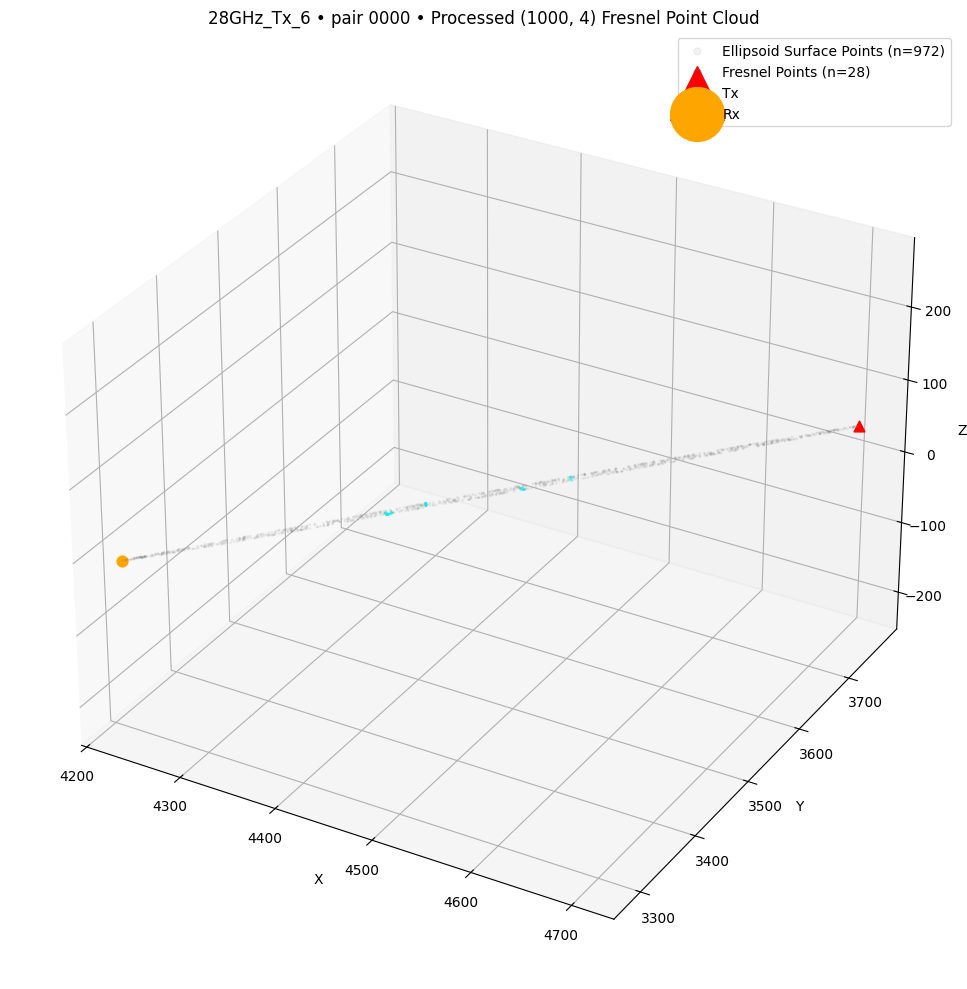

In [9]:
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt # Re-added for plotting

# Point this at the base 'train' or 'test' directory containing the Fresnel data
BASE_DIR_FOR_PREPROCESS = Path("/home/mkrishne/PL_competition/extracted_regions/train/28GHz_Tx_6/")
PAIR_IDX_FOR_PREPROCESS = 0  # which pair to process

# Define a point DENSITY for random sampling
POINTS_PER_SQUARE_METER = 0.1 # How many points to sample for every 1 sq meter of surface area

# NEW: Define the target fixed size for the point cloud
TARGET_POINTS = 1000 # Changed to 1000

# ---------- I/O helpers ----------
def _npz_path(base_dir: Path, pair_idx: int, tag: str) -> Path:
    # Uses the base directory directly
    return base_dir / f"pair{pair_idx:05d}_{tag}.npz"

def _load_region(base_dir: Path, pair_idx: int, tag: str):
    # Pass 'scene' to _npz_path
    path = _npz_path(base_dir, pair_idx, tag)
    if not path.exists():
        raise FileNotFoundError(f"Missing file: {path}")
    dat = np.load(path, allow_pickle=True)
    polys = [p for p in dat["polys"] if p is not None and len(p) >= 3]
    meta  = {k: dat[k] for k in dat.files if k != "polys"}
    # be safe about dtypes/shapes
    meta["Tx"] = np.array(meta["Tx"], dtype=float).reshape(-1)
    if "Rx" in meta:
        meta["Rx"] = np.array(meta["Rx"], dtype=float).reshape(-1)
    # Load T if it exists (needed for ellipsoid sampling)
    if "T" in meta:
         meta["T"] = float(meta["T"])
    return polys, meta

# ---------- Point Cloud Sampling Helpers ----------
def _triangulate_polygon(poly):
    """Assumes a convex polygon and creates a triangle fan."""
    if len(poly) < 3:
        return []
    V0 = poly[0]
    triangles = []
    for i in range(1, len(poly) - 1):
        V1 = poly[i]
        V2 = poly[i+1]
        triangles.append((V0, V1, V2))
    return triangles

def _point_in_triangle_2d(pt, v0, v1, v2):
    """
    Checks if a 2D point is inside a 2D triangle.
    Uses the "Sign of Half-Planes" method (robust and fast).
    """
    def sign(p1, p2, p3):
        return (p1[0] - p3[0]) * (p2[1] - p3[1]) - (p2[0] - p3[0]) * (p1[1] - p3[1])
    d1 = sign(pt, v0, v1)
    d2 = sign(pt, v1, v2)
    d3 = sign(pt, v2, v0)
    # Check for floating point inaccuracies near zero
    has_neg = (d1 < -1e-9) or (d2 < -1e-9) or (d3 < -1e-9)
    has_pos = (d1 > 1e-9) or (d2 > 1e-9) or (d3 > 1e-9)
    # Point is inside or on the edge if all signs are the same
    return not (has_neg and has_pos)

def sample_mesh_surface(polys, points_per_sq_meter):
    """
    Samples points from the surface of the mesh using a UNIFORM GRID.
    Total points sampled is proportional to the total surface area.
    """
    all_triangles = []
    total_area = 0.0
    
    # 1. Triangulate all polygons and calculate their total area
    for poly in polys:
        triangles_in_poly = _triangulate_polygon(poly)
        for tri in triangles_in_poly:
            V0, V1, V2 = tri
            area = 0.5 * np.linalg.norm(np.cross(V1 - V0, V2 - V0))
            if area > 1e-9: # Avoid degenerate triangles
                all_triangles.append(tri)
                total_area += area
    if total_area == 0:
        print("No valid triangle area found. Returning empty point cloud.")
        return np.array([]).reshape(0, 3)
        
    # 2. Calculate grid spacing
    grid_step = 1.0 / np.sqrt(points_per_sq_meter)
    points_sampled = []
    
    print(f"Total mesh area: {total_area:.2f} sq m. Sampling with grid step {grid_step:.3f} m.")
    # 3. Loop over all triangles and sample grid points on their surface
    for tri in all_triangles:
        V0, V1, V2 = tri
        
        # 1. Create the 2D orthonormal basis for the triangle's plane
        u_vec = V1 - V0
        v_vec_unscaled = V2 - V0
        
        u_len = np.linalg.norm(u_vec)
        if u_len < 1e-9: continue # Degenerate edge
        
        u_axis = u_vec / u_len
        
        # Get the component of v_vec_unscaled projected onto u_axis
        v_proj_u_scalar = np.dot(v_vec_unscaled, u_axis)
        
        # Get the component of v_vec_unscaled perpendicular to u_axis
        v_vec_perp = v_vec_unscaled - v_proj_u_scalar * u_axis
        
        v_len = np.linalg.norm(v_vec_perp)
        if v_len < 1e-9: continue # Degenerate triangle (collinear vertices)
        
        v_axis = v_vec_perp / v_len
        
        # 2. Define the 2D triangle vertices in this new basis (V0 is origin)
        v0_2d = np.array([0.0, 0.0])
        v1_2d = np.array([u_len, 0.0])
        v2_2d = np.array([v_proj_u_scalar, v_len])
        
        # 3. Find the 2D bounding box of the triangle in this basis
        min_x = min(v0_2d[0], v1_2d[0], v2_2d[0]) - 1e-9
        max_x = max(v0_2d[0], v1_2d[0], v2_2d[0]) + 1e-9
        min_y = min(v0_2d[1], v1_2d[1], v2_2d[1]) - 1e-9
        max_y = max(v0_2d[1], v1_2d[1], v2_2d[1]) + 1e-9
        
        # 4. Determine grid loop range
        x_start = np.floor(min_x / grid_step) * grid_step
        y_start = np.floor(min_y / grid_step) * grid_step
        
        n_steps_x = int(np.ceil((max_x - x_start) / grid_step)) + 1
        n_steps_y = int(np.ceil((max_y - y_start) / grid_step)) + 1
        
        # 5. Loop over grid points in the 2D bounding box
        for i in range(n_steps_x):
            x = x_start + i * grid_step
            for j in range(n_steps_y):
                y = y_start + j * grid_step
                
                pt_2d = np.array([x, y])
                
                # 6. Check if the 2D grid point is inside the 2D triangle
                if _point_in_triangle_2d(pt_2d, v0_2d, v1_2d, v2_2d):
                    # 7. Convert 2D basis point back to 3D and store
                    P_3d = V0 + x * u_axis + y * v_axis
                    points_sampled.append(P_3d)

    if not points_sampled:
        print("No points sampled (grid step might be larger than any triangle).")
        return np.array([]).reshape(0, 3)

    # 8. De-duplicate points
    all_points = np.array(points_sampled)
    precision_decimals = int(np.ceil(-np.log10(grid_step)) + 2)
    unique_points = np.unique(all_points.round(decimals=precision_decimals), axis=0)
    
    print(f"Sampled {unique_points.shape[0]} unique grid points.")
    return unique_points
    
# ---------- NEW HELPER for Ellipsoid Sampling ----------
def _sample_ellipsoid_surface(T, Tx, Rx, n_points):
    """
    Samples n_points uniformly from the surface of a Fresnel ellipsoid.
    Uses a variation of sphere sampling, scaled and rotated.
    """
    if n_points <= 0:
        return np.array([]).reshape(0, 3)

    # 1. Calculate ellipsoid parameters
    D = float(np.linalg.norm(Rx - Tx))
    if D < 1e-9: # Avoid issues if Tx == Rx
        # Sample from a sphere instead
        center = Tx
        radius = T / 2.0 # Treat T as diameter
        vec = np.random.randn(n_points, 3)
        vec_norm = np.linalg.norm(vec, axis=1, keepdims=True)
        vec_norm[vec_norm == 0] = 1.0
        vec = vec / vec_norm
        points = vec * radius + center
        return points

    a = T / 2.0 # Semi-major axis (along Tx-Rx)
    c = D / 2.0 # Distance from center to focus (Tx or Rx)
    # Ensure b^2 is non-negative
    b_squared = a*a - c*c
    if b_squared < 0:
        print(f"Warning: T ({T}) is smaller than distance D ({D}). Cannot form ellipsoid. Sampling sphere instead.")
        # Fallback to sphere sampling around the midpoint
        center = 0.5 * (Tx + Rx)
        radius = T / 2.0 
        vec = np.random.randn(n_points, 3)
        vec_norm = np.linalg.norm(vec, axis=1, keepdims=True)
        vec_norm[vec_norm == 0] = 1.0
        vec = vec / vec_norm
        points = vec * radius + center
        return points
        
    b = np.sqrt(b_squared) # Semi-minor axis
    center = 0.5 * (Tx + Rx)

    # 2. Generate points on a unit sphere
    vec = np.random.randn(n_points, 3)
    vec_norm = np.linalg.norm(vec, axis=1, keepdims=True)
    vec_norm[vec_norm == 0] = 1.0
    vec_unit_sphere = vec / vec_norm

    # 3. Scale points to form an axis-aligned ellipsoid at origin
    # Treat the first dimension (X) as the major axis
    points_scaled = vec_unit_sphere * np.array([a, b, b])

    # 4. Calculate rotation matrix to align with Tx-Rx vector
    u = (Rx - Tx) / D # Direction vector Tx -> Rx
    
    # Find perpendicular vectors v and w using Gram-Schmidt
    tmp = np.array([0.0,0.0,1.0]) if abs(np.dot(u,[0,0,1])) < 0.9 else np.array([0.0,1.0,0.0])
    v = np.cross(u, tmp)
    v /= (np.linalg.norm(v) + 1e-15)
    w = np.cross(u, v)
    w /= (np.linalg.norm(w) + 1e-15) # Should be unit length already if u,v are
    
    # Rotation matrix (columns are u, v, w) - transforms local coords to world coords
    rotation_matrix = np.column_stack([u, v, w])

    # 5. Rotate and translate points
    # Apply rotation: points_rotated = points_scaled @ rotation_matrix.T
    # Apply translation: points = points_rotated + center
    points = points_scaled @ rotation_matrix.T + center
    
    return points

# ---------- Plotting Function (Updated Labels) ----------
def plot_processed_cloud(output_array, tx_coord, rx_coord, base_dir, pair_idx):
    """
    Plots the final (N, 4) processed point cloud for Fresnel zone.
    Distinguishes building points from ellipsoid surface points.
    """
    if output_array.shape[0] == 0:
        print("Cannot plot empty point cloud.")
        return

    points_xyz = output_array[:, :3]
    is_building = output_array[:, 3] == 1
    is_ellipsoid = ~is_building # Points with flag 0
    
    points_building = points_xyz[is_building]
    points_ellipsoid = points_xyz[is_ellipsoid]
    
    fig = plt.figure(figsize=(12, 10))
    ax = fig.add_subplot(111, projection='3d')

    # Plot ellipsoid surface points (if any)
    if points_ellipsoid.shape[0] > 0:
         ax.scatter(
             points_ellipsoid[:, 0], points_ellipsoid[:, 1], points_ellipsoid[:, 2],
             s=1, color='gray', alpha=0.1, label=f'Ellipsoid Surface Points (n={points_ellipsoid.shape[0]})'
         )

    # Plot building points (if any)
    if points_building.shape[0] > 0:
        ax.scatter(
            points_building[:, 0], points_building[:, 1], points_building[:, 2],
            s=1, color='cyan', label=f'Fresnel Points (n={points_building.shape[0]})'
        )
        
    # Plot the original Tx position
    ax.scatter(tx_coord[0], tx_coord[1], tx_coord[2], s=60, marker='^', label='Tx', color='red')
    # Plot the original Rx position
    ax.scatter(rx_coord[0], rx_coord[1], rx_coord[2], s=60, marker='o', label='Rx', color='orange')
    
    ax.set_xlabel('X'); ax.set_ylabel('Y'); ax.set_zlabel('Z')
    ax.set_title(f'{base_dir.name} • pair {pair_idx:04d} • Processed (1000, 4) Fresnel Point Cloud')

    # Set equal aspect ratio
    all_pts_for_plot = np.vstack([points_xyz, tx_coord.reshape(1,3), rx_coord.reshape(1,3)])
    mins = all_pts_for_plot.min(axis=0); maxs = all_pts_for_plot.max(axis=0)
    
    center = (maxs + mins) / 2.0
    span = maxs - mins
    max_span = np.max(span) * 1.1 
    
    if max_span == 0: # Handle case with only one point
        max_span = 1.0
    
    ax.set_xlim(center[0] - max_span / 2.0, center[0] + max_span / 2.0)
    ax.set_ylim(center[1] - max_span / 2.0, center[1] + max_span / 2.0)
    ax.set_zlim(center[2] - max_span / 2.0, center[2] + max_span / 2.0)

    ax.legend(loc='upper right', markerscale=5)
    plt.tight_layout()
    plt.show()


# ---------- Main Preprocessing Function (Updated Sampling Logic) ----------
def preprocess_and_save(base_dir: Path, pair_idx: int, target_points: int):
    
    print(f"--- Processing pair {pair_idx} in {base_dir.name} ---")
    
    # 1. Load regions (Fresnel zone only)
    try:
        polys_FN, meta_FN = _load_region(base_dir, pair_idx, "fresnel3") # Load fresnel1
    except FileNotFoundError as e:
        print(e)
        print(f"Trying to find: {base_dir / f'pair{pair_idx:05d}_fresnel1.npz'}")
        print("Cannot preprocess. Exiting.")
        return

    # 2. Get metadata
    if "Tx" not in meta_FN or "Rx" not in meta_FN:
         print("Error: Tx or Rx not found in metadata.")
         return
    Tx = meta_FN["Tx"]
    Rx = meta_FN["Rx"]
    # Get T parameter, needed for ellipsoid sampling
    if "T" not in meta_FN:
         print("Error: T parameter not found in metadata. Cannot sample ellipsoid surface.")
         return
    T = meta_FN["T"] 
    
    # 3. Sample building mesh to get initial point cloud
    pc_buildings = sample_mesh_surface(polys_FN, POINTS_PER_SQUARE_METER)
    
    # 4. Normalization steps REMOVED
    pc_buildings_norm = pc_buildings # Use original points
    
    n_building_points = pc_buildings_norm.shape[0]
    print(f"Found {n_building_points} Fresnel points.")

    # 5. Apply fixed-size logic (Sub-sample buildings or Add ellipsoid points)
    if n_building_points == 0:
        print(f"Warning: No Fresnel geometry found. Sampling {target_points} points from ellipsoid surface.")
        # Sample all points from ellipsoid
        pc_ellipsoid = _sample_ellipsoid_surface(T, Tx, Rx, target_points)
        pc_final = pc_ellipsoid
        features_final = np.zeros((target_points, 1)) # All points are ellipsoid surface

    elif n_building_points > target_points:
        # Case 1: Too many points. Randomly sub-sample buildings.
        print(f"Sub-sampling buildings to {target_points} points.")
        indices = np.random.choice(n_building_points, target_points, replace=False)
        pc_final = pc_buildings_norm[indices]
        features_final = np.ones((target_points, 1)) # All points are buildings
        
    elif n_building_points < target_points:
        # Case 2: Too few points. Add points from ellipsoid surface.
        num_to_add = target_points - n_building_points
        print(f"Adding {num_to_add} points from ellipsoid surface.")
        
        # Sample ellipsoid points (in global coordinates)
        pc_ellipsoid = _sample_ellipsoid_surface(T, Tx, Rx, num_to_add)
        
        # Combine building points and ellipsoid points
        pc_final = np.vstack([pc_buildings_norm, pc_ellipsoid])
        
        # Create corresponding features (1 for building, 0 for ellipsoid)
        features_build = np.ones((n_building_points, 1))
        features_ellipsoid = np.zeros((num_to_add, 1))
        features_final = np.vstack([features_build, features_ellipsoid])
        
    else:
        # Case 3: Exactly the right number of points.
        print(f"Found exactly {target_points} points. No sampling needed.")
        pc_final = pc_buildings_norm
        features_final = np.ones((target_points, 1))

    # 6. Combine into final (N, 4) array
    # Ensure pc_final and features_final are correctly shaped even if empty
    if pc_final.shape[0] == 0:
         output_array = np.empty((0, 4))
    else:
         output_array = np.hstack([pc_final, features_final])
    
    # 7. Save the processed array
    output_filename = base_dir / f"pair{pair_idx:05d}_processed_pc_fresnel.npy" # MODIFIED filename
    np.save(output_filename, output_array.astype(np.float32)) # Save as float32
    
    print(f"\nSuccessfully saved processed point cloud to:")
    print(f"{output_filename}")
    print(f"Final array shape: {output_array.shape}")
    
    # 8. Optional: Print stats for verification
    if output_array.shape[0] > 0:
        pc_min = output_array[:, :3].min(axis=0)
        pc_max = output_array[:, :3].max(axis=0)
        print("\n=== Final Point Cloud Stats (Original Coords) ===")
        print(f"X: min={pc_min[0]:.3f}, max={pc_max[0]:.3f}")
        print(f"Y: min={pc_min[1]:.3f}, max={pc_max[1]:.3f}")
        print(f"Z: min={pc_min[2]:.3f}, max={pc_max[2]:.3f}")
        print(f"is_building: {int(features_final.sum())} / {target_points} points")
        print("==========================================")
        
        # Print first/last points
        print("\n=== First 5 Points (X, Y, Z, is_building) ===")
        print(output_array[:5])
        print("\n=== Last 5 Points (X, Y, Z, is_building) ===")
        print(output_array[-5:])
        print("==========================================\n")
        
    # 9. Plot the final processed cloud
    plot_processed_cloud(output_array, Tx, Rx, base_dir, pair_idx)


# ---- Run ----
if __name__ == "__main__":
    if not BASE_DIR_FOR_PREPROCESS.exists():
        print(f"Error: Path not found. Please update BASE_DIR_FOR_PREPROCESS in the script.")
        print(f"Current path: {BASE_DIR_FOR_PREPROCESS}")
    else:
        preprocess_and_save(BASE_DIR_FOR_PREPROCESS, PAIR_IDX_FOR_PREPROCESS, TARGET_POINTS)



In [1]:
import numpy as np
from pathlib import Path
import re # Added for extracting pair index from filename
# Plotting imports removed as plotting is disabled for batch processing
# import matplotlib.pyplot as plt

# Point this at the base 'train' or 'test' directory
BASE_TRAIN_DIR = Path("/home/mkrishne/PL_competition/extracted_regions/train/")

# --- NEW: Define the specific list of scene folders to process ---
SCENE_NAMES_TO_PROCESS = [
    "800MHz_Tx_1",
]
# -----------------------------------------------------------------

# Define a point DENSITY for random sampling
POINTS_PER_SQUARE_METER = 0.2 # How many points to sample for every 1 sq meter of surface area

# Define the target fixed size for the point cloud
TARGET_POINTS = 1000 # Changed to 1000

# Define the tag for the input Fresnel files
FRESNEL_TAG = "fresnel3" # Changed tag

# ---------- I/O helpers ----------
def _npz_path(scene_dir: Path, pair_idx: int, tag: str) -> Path:
    # Construct path using scene_dir/filename
    return scene_dir / f"pair{pair_idx:05d}_{tag}.npz"

def _load_region(scene_dir: Path, pair_idx: int, tag: str):
    # Pass 'scene_dir' Path object directly
    path = _npz_path(scene_dir, pair_idx, tag)
    if not path.exists():
        raise FileNotFoundError(f"Missing file: {path}")
    dat = np.load(path, allow_pickle=True)
    # Handle potentially missing 'polys' key gracefully
    polys = []
    if "polys" in dat:
        polys = [p for p in dat["polys"] if p is not None and len(p) >= 3]
    else:
        print(f"    Warning: 'polys' key not found in {path.name}")

    meta  = {k: dat[k] for k in dat.files if k != "polys"}
    # be safe about dtypes/shapes
    # Load Tx and Rx if they exist (needed for ellipsoid sampling)
    if "Tx" in meta:
         meta["Tx"] = np.array(meta["Tx"], dtype=float).reshape(-1)
    if "Rx" in meta:
        meta["Rx"] = np.array(meta["Rx"], dtype=float).reshape(-1)
    # Load T if it exists (needed for ellipsoid sampling)
    if "T" in meta:
         meta["T"] = float(meta["T"])
    return polys, meta

# ---------- Point Cloud Sampling Helpers ----------
def _triangulate_polygon(poly):
    """Assumes a convex polygon and creates a triangle fan."""
    if len(poly) < 3:
        return []
    V0 = poly[0]
    triangles = []
    for i in range(1, len(poly) - 1):
        V1 = poly[i]
        V2 = poly[i+1]
        triangles.append((V0, V1, V2))
    return triangles

def _point_in_triangle_2d(pt, v0, v1, v2):
    """
    Checks if a 2D point is inside a 2D triangle.
    Uses the "Sign of Half-Planes" method (robust and fast).
    """
    def sign(p1, p2, p3):
        return (p1[0] - p3[0]) * (p2[1] - p3[1]) - (p2[0] - p3[0]) * (p1[1] - p3[1])
    d1 = sign(pt, v0, v1)
    d2 = sign(pt, v1, v2)
    d3 = sign(pt, v2, v0)
    # Check for floating point inaccuracies near zero
    has_neg = (d1 < -1e-9) or (d2 < -1e-9) or (d3 < -1e-9)
    has_pos = (d1 > 1e-9) or (d2 > 1e-9) or (d3 > 1e-9)
    # Point is inside or on the edge if all signs are the same
    return not (has_neg and has_pos)

def sample_mesh_surface(polys, points_per_sq_meter):
    """
    Samples points from the surface of the mesh using a UNIFORM GRID.
    Total points sampled is proportional to the total surface area.
    """
    all_triangles = []
    total_area = 0.0

    # 1. Triangulate all polygons and calculate their total area
    for poly in polys:
        triangles_in_poly = _triangulate_polygon(poly)
        for tri in triangles_in_poly:
            V0, V1, V2 = tri
            area = 0.5 * np.linalg.norm(np.cross(V1 - V0, V2 - V0))
            if area > 1e-9: # Avoid degenerate triangles
                all_triangles.append(tri)
                total_area += area
    if total_area == 0:
        # Return empty array, but don't print warning here, handle in main func
        return np.array([]).reshape(0, 3)

    # 2. Calculate grid spacing
    # Avoid sqrt of zero or negative
    if points_per_sq_meter <= 1e-9:
         print(f"Warning: points_per_sq_meter ({points_per_sq_meter}) is too low. Cannot calculate grid_step.")
         return np.array([]).reshape(0, 3)

    grid_step = 1.0 / np.sqrt(points_per_sq_meter)
    points_sampled = []

    # 3. Loop over all triangles and sample grid points on their surface
    for tri in all_triangles:
        V0, V1, V2 = tri

        # 1. Create the 2D orthonormal basis for the triangle's plane
        u_vec = V1 - V0
        v_vec_unscaled = V2 - V0

        u_len = np.linalg.norm(u_vec)
        if u_len < 1e-9: continue # Degenerate edge

        u_axis = u_vec / u_len

        # Get the component of v_vec_unscaled projected onto u_axis
        v_proj_u_scalar = np.dot(v_vec_unscaled, u_axis)

        # Get the component of v_vec_unscaled perpendicular to u_axis
        v_vec_perp = v_vec_unscaled - v_proj_u_scalar * u_axis

        v_len = np.linalg.norm(v_vec_perp)
        if v_len < 1e-9: continue # Degenerate triangle (collinear vertices)

        v_axis = v_vec_perp / v_len

        # 2. Define the 2D triangle vertices in this new basis (V0 is origin)
        v0_2d = np.array([0.0, 0.0])
        v1_2d = np.array([u_len, 0.0])
        v2_2d = np.array([v_proj_u_scalar, v_len])

        # 3. Find the 2D bounding box of the triangle in this basis
        min_x = min(v0_2d[0], v1_2d[0], v2_2d[0]) - 1e-9
        max_x = max(v0_2d[0], v1_2d[0], v2_2d[0]) + 1e-9
        min_y = min(v0_2d[1], v1_2d[1], v2_2d[1]) - 1e-9
        max_y = max(v0_2d[1], v1_2d[1], v2_2d[1]) + 1e-9

        # 4. Determine grid loop range
        x_start = np.floor(min_x / grid_step) * grid_step
        y_start = np.floor(min_y / grid_step) * grid_step

        n_steps_x = int(np.ceil((max_x - x_start) / grid_step)) + 1
        n_steps_y = int(np.ceil((max_y - y_start) / grid_step)) + 1

        # 5. Loop over grid points in the 2D bounding box
        for i in range(n_steps_x):
            x = x_start + i * grid_step
            for j in range(n_steps_y):
                y = y_start + j * grid_step

                pt_2d = np.array([x, y])

                # 6. Check if the 2D grid point is inside the 2D triangle
                if _point_in_triangle_2d(pt_2d, v0_2d, v1_2d, v2_2d):
                    # 7. Convert 2D basis point back to 3D and store
                    P_3d = V0 + x * u_axis + y * v_axis
                    points_sampled.append(P_3d)

    if not points_sampled:
        # Return empty array, but don't print warning here
        return np.array([]).reshape(0, 3)

    # 8. De-duplicate points
    all_points = np.array(points_sampled)
    precision_decimals = int(np.ceil(-np.log10(grid_step)) + 2)
    unique_points = np.unique(all_points.round(decimals=precision_decimals), axis=0)

    # Don't print stats here, do it in main func
    return unique_points

# ---------- Ellipsoid Sampling Helper ADDED BACK ----------
def _sample_ellipsoid_surface(T, Tx, Rx, n_points):
    """
    Samples n_points uniformly from the surface of a Fresnel ellipsoid.
    Uses a variation of sphere sampling, scaled and rotated.
    """
    if n_points <= 0:
        return np.array([]).reshape(0, 3)

    # 1. Calculate ellipsoid parameters
    D = float(np.linalg.norm(Rx - Tx))
    if D < 1e-9: # Avoid issues if Tx == Rx
        # Sample from a sphere instead
        print(f"    Warning: Tx and Rx are coincident for pair. Sampling sphere instead of ellipsoid.")
        center = Tx
        radius = T / 2.0 # Treat T as diameter
        vec = np.random.randn(n_points, 3)
        vec_norm = np.linalg.norm(vec, axis=1, keepdims=True)
        vec_norm[vec_norm == 0] = 1.0
        vec = vec / vec_norm
        points = vec * radius + center
        return points

    a = T / 2.0 # Semi-major axis (along Tx-Rx)
    c = D / 2.0 # Distance from center to focus (Tx or Rx)
    # Ensure b^2 is non-negative
    b_squared = a*a - c*c
    if b_squared < 0:
        print(f"    Warning: T ({T}) is smaller than distance D ({D}). Cannot form ellipsoid. Sampling sphere instead.")
        # Fallback to sphere sampling around the midpoint
        center = 0.5 * (Tx + Rx)
        radius = T / 2.0
        vec = np.random.randn(n_points, 3)
        vec_norm = np.linalg.norm(vec, axis=1, keepdims=True)
        vec_norm[vec_norm == 0] = 1.0
        vec = vec / vec_norm
        points = vec * radius + center
        return points

    b = np.sqrt(b_squared) # Semi-minor axis
    center = 0.5 * (Tx + Rx)

    # 2. Generate points on a unit sphere
    vec = np.random.randn(n_points, 3)
    vec_norm = np.linalg.norm(vec, axis=1, keepdims=True)
    vec_norm[vec_norm == 0] = 1.0
    vec_unit_sphere = vec / vec_norm

    # 3. Scale points to form an axis-aligned ellipsoid at origin
    # Treat the first dimension (X) as the major axis
    points_scaled = vec_unit_sphere * np.array([a, b, b])

    # 4. Calculate rotation matrix to align with Tx-Rx vector
    u = (Rx - Tx) / D # Direction vector Tx -> Rx

    # Find perpendicular vectors v and w using Gram-Schmidt
    tmp = np.array([0.0,0.0,1.0]) if abs(np.dot(u,[0,0,1])) < 0.9 else np.array([0.0,1.0,0.0])
    v = np.cross(u, tmp)
    v /= (np.linalg.norm(v) + 1e-15)
    w = np.cross(u, v)
    w /= (np.linalg.norm(w) + 1e-15) # Should be unit length already if u,v are

    # Rotation matrix (columns are u, v, w) - transforms local coords to world coords
    rotation_matrix = np.column_stack([u, v, w])

    # 5. Rotate and translate points
    # Apply rotation: points_rotated = points_scaled @ rotation_matrix.T
    # Apply translation: points = points_rotated + center
    points = points_scaled @ rotation_matrix.T + center

    return points

# ---------- Plotting Function REMOVED ----------

# ---------- Main Preprocessing Function (modified for Fresnel batch) ----------
def preprocess_and_save(scene_dir: Path, pair_idx: int, tag: str, target_points: int, output_dir: Path):

    # --- ADDED: Check if output file already exists ---
    output_filename = output_dir / f"pair{pair_idx:05d}_processed_pc_{tag}.npy" # Use tag in filename
    if output_filename.exists():
        # print(f"    Skipping pair {pair_idx}: Output file already exists.") # Optional: uncomment for verbose skipping
        return True # Indicate success (already done)
    # --- END ADDITION ---


    # print(f"--- Processing pair {pair_idx} in {scene_dir.name} ---") # Removed repetitive print

    # 1. Load regions (Fresnel only)
    try:
        polys_FN, meta_FN = _load_region(scene_dir, pair_idx, tag)
    except FileNotFoundError:
        # print(f"    Skipping pair {pair_idx}: Input file not found.") # Removed print
        return False # Indicate skip/fail
    except Exception as e:
        print(f"    Skipping pair {pair_idx}: Error loading file - {e}") # Keep error prints
        return False # Indicate skip/fail

    # 2. Get metadata (Ensure Tx, Rx, T are available for ellipsoid sampling)
    if "Tx" not in meta_FN or "Rx" not in meta_FN:
         # print(f"    Skipping pair {pair_idx}: Tx or Rx not found in metadata.") # Removed print
         return False # Indicate skip/fail
    Tx = meta_FN["Tx"]
    Rx = meta_FN["Rx"]
    if "T" not in meta_FN:
         # print(f"    Skipping pair {pair_idx}: T parameter not found in metadata.") # Removed print
         return False # Indicate skip/fail
    T = meta_FN["T"]

    # 3. Sample building mesh to get initial point cloud
    pc_buildings = sample_mesh_surface(polys_FN, POINTS_PER_SQUARE_METER)

    # Use original coordinates (no normalization)
    pc_buildings_norm = pc_buildings

    n_building_points = pc_buildings_norm.shape[0]
    # print(f"    Found {n_building_points} Fresnel points from geometry.") # Removed print

    # 4. Apply fixed-size logic (Sub-sample buildings or Add ellipsoid points)
    if n_building_points == 0:
        # Case 0: No building points. Sample all from ellipsoid surface.
        # print(f"    Warning: No Fresnel geometry found. Sampling {target_points} points from ellipsoid surface.") # Removed print
        pc_ellipsoid = _sample_ellipsoid_surface(T, Tx, Rx, target_points)

        # Check if ellipsoid sampling returned enough points
        if pc_ellipsoid.shape[0] < target_points:
             # print(f"    Warning: Could only sample {pc_ellipsoid.shape[0]} ellipsoid points for pair {pair_idx}. Skipping save.") # Removed print
             return False # Indicate skip/fail

        pc_final = pc_ellipsoid
        features_final = np.zeros((target_points, 1)) # All points are ellipsoid surface (flag 0)

    elif n_building_points > target_points:
        # Case 1: Too many points. Randomly sub-sample buildings.
        # print(f"    Sub-sampling Fresnel points to {target_points}.") # Removed print
        indices = np.random.choice(n_building_points, target_points, replace=False)
        pc_final = pc_buildings_norm[indices]
        features_final = np.ones((target_points, 1)) # All points are buildings (flag 1)

    elif n_building_points < target_points:
        # --- MODIFIED: Add points from ellipsoid surface ---
        num_to_add = target_points - n_building_points
        # print(f"    Adding {num_to_add} points from ellipsoid surface.") # Removed print

        # Sample ellipsoid points (in global coordinates)
        pc_ellipsoid = _sample_ellipsoid_surface(T, Tx, Rx, num_to_add)

        # Check if ellipsoid sampling returned enough points
        if pc_ellipsoid.shape[0] < num_to_add:
             # print(f"    Warning: Could only sample {pc_ellipsoid.shape[0]} ellipsoid points for pair {pair_idx}. Skipping save.") # Removed print
             return False # Indicate skip/fail

        # Combine building points and ellipsoid points
        pc_final = np.vstack([pc_buildings_norm, pc_ellipsoid])

        # Create corresponding features (1 for building, 0 for ellipsoid)
        features_build = np.ones((n_building_points, 1))
        features_ellipsoid = np.zeros((num_to_add, 1))
        features_final = np.vstack([features_build, features_ellipsoid])
        # --- End Modification ---

    else:
        # Case 3: Exactly the right number of points.
        # print(f"    Found exactly {target_points} points. No sampling needed.") # Removed print
        pc_final = pc_buildings_norm
        features_final = np.ones((target_points, 1)) # All points are buildings (flag 1)

    # 5. Combine into final (N, 4) array
    # Ensure pc_final and features_final are correctly shaped
    if pc_final.shape[0] != target_points:
        print(f"    Error: Final point cloud size ({pc_final.shape[0]}) doesn't match target ({target_points}) for pair {pair_idx}. Skipping save.") # Keep error print
        return False # Indicate skip/fail

    output_array = np.hstack([pc_final, features_final])

    # 6. Save the processed array to the specified output directory
    # output_filename = output_dir / f"pair{pair_idx:05d}_processed_pc_{tag}.npy" # Defined earlier for check
    try:
        np.save(output_filename, output_array.astype(np.float32)) # Save as float32
        # --- MODIFIED: Print full path on success ---
        print(f"    Saved: {output_filename}")
        # --- END MODIFICATION ---
        return True # Indicate success
    except Exception as e:
        print(f"    Error saving file {output_filename.name}: {e}") # Keep error print
        return False # Indicate skip/fail


# ---- Batch Processing Runner ----
if __name__ == "__main__":

    if not BASE_TRAIN_DIR.exists():
        print(f"Error: Base training directory not found: {BASE_TRAIN_DIR}")
        exit()

    processed_count = 0
    skipped_count = 0
    already_exist_count = 0 # --- ADDED counter ---

    # --- Iterate through the predefined list ---
    print(f"Processing {len(SCENE_NAMES_TO_PROCESS)} specified scene directories...")

    for scene_name in SCENE_NAMES_TO_PROCESS:
        scene_dir = BASE_TRAIN_DIR / scene_name

        # Check if the specific directory exists
        if not scene_dir.is_dir():
            print(f"\nWarning: Directory not found, skipping: {scene_dir}")
            continue

        print(f"\nProcessing directory: {scene_dir.name}") # Keep print

        # Create corresponding output directory name using regex
        # Example: 28GHz_Tx_1 -> 28GHz_processed_Tx_1
        output_dir_name = re.sub(r'(GHz|MHz)_Tx_', r'\1_processed_Tx_', scene_name)
        output_dir = BASE_TRAIN_DIR / output_dir_name

        # Create the output directory if it doesn't exist
        try:
            output_dir.mkdir(parents=True, exist_ok=True)
            # print(f"  Ensured output directory exists: {output_dir.name}") # Removed print
        except OSError as e:
            print(f"  Error creating output directory {output_dir.name}: {e}. Skipping this directory.") # Keep error print
            # Estimate skipped files based on input files found
            skipped_count += len(list(scene_dir.glob(f"pair*_{FRESNEL_TAG}.npz")))
            continue

        # Find all input npz files in the current scene directory
        input_files = sorted(scene_dir.glob(f"pair*_{FRESNEL_TAG}.npz"))

        if not input_files:
            print("  No input files found in this directory.") # Keep print
            continue

        # print(f"  Found {len(input_files)} input files...") # Removed print

        # Process each file
        for input_file in input_files:
            # Extract pair index from filename using regex
            match = re.search(r'pair(\d{5})_', input_file.name)
            if match:
                pair_idx = int(match.group(1))

                # --- ADDED: Check if output exists BEFORE calling preprocess ---
                expected_output_filename = output_dir / f"pair{pair_idx:05d}_processed_pc_{FRESNEL_TAG}.npy" # Use tag in check
                if expected_output_filename.exists():
                    already_exist_count += 1
                    continue # Skip to the next file
                # --- END ADDITION ---

                try:
                    # Pass FRESNEL_TAG to the function
                    success = preprocess_and_save(scene_dir, pair_idx, FRESNEL_TAG, TARGET_POINTS, output_dir)
                    if success:
                         processed_count += 1
                    else:
                         skipped_count += 1
                except Exception as e:
                    # Catch any unexpected errors during processing a single file
                    print(f"\n    Unexpected error processing pair {pair_idx}: {e}") # Keep error print
                    skipped_count += 1
            else:
                print(f"\n    Could not extract pair index from filename: {input_file.name}. Skipping.") # Keep error print
                skipped_count += 1

    # --- END OF LOOP ---

    print("\n--- Batch Processing Complete ---") # Keep final summary
    print(f"Successfully processed: {processed_count} files")
    print(f"Skipped (already exist): {already_exist_count} files") # --- ADDED ---
    print(f"Skipped (Error/Missing): {skipped_count} files") # Clarified skip reason
    print("---------------------------------")

Processing 1 specified scene directories...

Processing directory: 800MHz_Tx_1
    Saved: /home/mkrishne/PL_competition/extracted_regions/train/800MHz_processed_Tx_1/pair00000_processed_pc_fresnel3.npy
    Saved: /home/mkrishne/PL_competition/extracted_regions/train/800MHz_processed_Tx_1/pair00001_processed_pc_fresnel3.npy
    Saved: /home/mkrishne/PL_competition/extracted_regions/train/800MHz_processed_Tx_1/pair00002_processed_pc_fresnel3.npy
    Saved: /home/mkrishne/PL_competition/extracted_regions/train/800MHz_processed_Tx_1/pair00003_processed_pc_fresnel3.npy
    Saved: /home/mkrishne/PL_competition/extracted_regions/train/800MHz_processed_Tx_1/pair00004_processed_pc_fresnel3.npy
    Saved: /home/mkrishne/PL_competition/extracted_regions/train/800MHz_processed_Tx_1/pair00005_processed_pc_fresnel3.npy
    Saved: /home/mkrishne/PL_competition/extracted_regions/train/800MHz_processed_Tx_1/pair00006_processed_pc_fresnel3.npy
    Saved: /home/mkrishne/PL_competition/extracted_regions/t

In [2]:
import numpy as np
from pathlib import Path
import re # Added for extracting pair index from filename

# Point this at the base 'train' or 'test' directory
BASE_TRAIN_DIR = Path("/home/mkrishne/PL_competition/extracted_regions/train/")

# --- NEW: Define the specific list of scene folders to process ---
SCENE_NAMES_TO_PROCESS = [
    "rx_sphere_Tx_1",
]
# -----------------------------------------------------------------

# Define a point DENSITY for random sampling
POINTS_PER_SQUARE_METER = 0.1 # How many points to sample for every 1 sq meter of surface area

# Define the target fixed size for the point cloud
TARGET_POINTS = 3000

# Define the tag for the input Rx sphere files
RX_SPHERE_TAG = "rx_sphere50"

# ---------- I/O helpers ----------
def _npz_path(scene_dir: Path, pair_idx: int, tag: str) -> Path:
    # Construct path using scene_dir/filename
    return scene_dir / f"pair{pair_idx:05d}_{tag}.npz"

def _load_region(scene_dir: Path, pair_idx: int, tag: str):
    # Pass 'scene_dir' Path object directly
    path = _npz_path(scene_dir, pair_idx, tag)
    if not path.exists():
        raise FileNotFoundError(f"Missing file: {path}")
    dat = np.load(path, allow_pickle=True)
    polys = []
    if "polys" in dat:
        polys = [p for p in dat["polys"] if p is not None and len(p) >= 3]
    # else: # Removed warning print
        # print(f"    Warning: 'polys' key not found in {path.name}")
    meta  = {k: dat[k] for k in dat.files if k != "polys"}
    # be safe about dtypes/shapes
    # Try loading Tx, but don't require it
    if "Tx" in meta:
         meta["Tx"] = np.array(meta["Tx"], dtype=float).reshape(-1)
    if "Rx" in meta:
        meta["Rx"] = np.array(meta["Rx"], dtype=float).reshape(-1)
    # Load R if it exists
    if "R" in meta:
         meta["R"] = float(meta["R"])
    return polys, meta

# ---------- Point Cloud Sampling Helpers ----------
def _triangulate_polygon(poly):
    """Assumes a convex polygon and creates a triangle fan."""
    if len(poly) < 3:
        return []
    V0 = poly[0]
    triangles = []
    for i in range(1, len(poly) - 1):
        V1 = poly[i]
        V2 = poly[i+1]
        triangles.append((V0, V1, V2))
    return triangles

def _point_in_triangle_2d(pt, v0, v1, v2):
    """
    Checks if a 2D point is inside a 2D triangle.
    Uses the "Sign of Half-Planes" method (robust and fast).
    """
    def sign(p1, p2, p3):
        return (p1[0] - p3[0]) * (p2[1] - p3[1]) - (p2[0] - p3[0]) * (p1[1] - p3[1])
    d1 = sign(pt, v0, v1)
    d2 = sign(pt, v1, v2)
    d3 = sign(pt, v2, v0)
    # Check for floating point inaccuracies near zero
    has_neg = (d1 < -1e-9) or (d2 < -1e-9) or (d3 < -1e-9)
    has_pos = (d1 > 1e-9) or (d2 > 1e-9) or (d3 > 1e-9)
    # Point is inside or on the edge if all signs are the same
    return not (has_neg and has_pos)

def sample_mesh_surface(polys, points_per_sq_meter):
    """
    Samples points from the surface of the mesh using a UNIFORM GRID.
    Total points sampled is proportional to the total surface area.
    """
    all_triangles = []
    total_area = 0.0

    # 1. Triangulate all polygons and calculate their total area
    for poly in polys:
        triangles_in_poly = _triangulate_polygon(poly)
        for tri in triangles_in_poly:
            V0, V1, V2 = tri
            area = 0.5 * np.linalg.norm(np.cross(V1 - V0, V2 - V0))
            if area > 1e-9: # Avoid degenerate triangles
                all_triangles.append(tri)
                total_area += area
    if total_area == 0:
        # Return empty array, but don't print warning here, handle in main func
        return np.array([]).reshape(0, 3)

    # 2. Calculate grid spacing
    # Avoid sqrt of zero or negative
    if points_per_sq_meter <= 1e-9:
         # print(f"Warning: points_per_sq_meter ({points_per_sq_meter}) is too low. Cannot calculate grid_step.") # Removed print
         return np.array([]).reshape(0, 3)

    grid_step = 1.0 / np.sqrt(points_per_sq_meter)
    points_sampled = []

    # 3. Loop over all triangles and sample grid points on their surface
    for tri in all_triangles:
        V0, V1, V2 = tri

        # 1. Create the 2D orthonormal basis for the triangle's plane
        u_vec = V1 - V0
        v_vec_unscaled = V2 - V0

        u_len = np.linalg.norm(u_vec)
        if u_len < 1e-9: continue # Degenerate edge

        u_axis = u_vec / u_len

        # Get the component of v_vec_unscaled projected onto u_axis
        v_proj_u_scalar = np.dot(v_vec_unscaled, u_axis)

        # Get the component of v_vec_unscaled perpendicular to u_axis
        v_vec_perp = v_vec_unscaled - v_proj_u_scalar * u_axis

        v_len = np.linalg.norm(v_vec_perp)
        if v_len < 1e-9: continue # Degenerate triangle (collinear vertices)

        v_axis = v_vec_perp / v_len

        # 2. Define the 2D triangle vertices in this new basis (V0 is origin)
        v0_2d = np.array([0.0, 0.0])
        v1_2d = np.array([u_len, 0.0])
        v2_2d = np.array([v_proj_u_scalar, v_len])

        # 3. Find the 2D bounding box of the triangle in this basis
        min_x = min(v0_2d[0], v1_2d[0], v2_2d[0]) - 1e-9
        max_x = max(v0_2d[0], v1_2d[0], v2_2d[0]) + 1e-9
        min_y = min(v0_2d[1], v1_2d[1], v2_2d[1]) - 1e-9
        max_y = max(v0_2d[1], v1_2d[1], v2_2d[1]) + 1e-9

        # 4. Determine grid loop range
        x_start = np.floor(min_x / grid_step) * grid_step
        y_start = np.floor(min_y / grid_step) * grid_step

        n_steps_x = int(np.ceil((max_x - x_start) / grid_step)) + 1
        n_steps_y = int(np.ceil((max_y - y_start) / grid_step)) + 1

        # 5. Loop over grid points in the 2D bounding box
        for i in range(n_steps_x):
            x = x_start + i * grid_step
            for j in range(n_steps_y):
                y = y_start + j * grid_step

                pt_2d = np.array([x, y])

                # 6. Check if the 2D grid point is inside the 2D triangle
                if _point_in_triangle_2d(pt_2d, v0_2d, v1_2d, v2_2d):
                    # 7. Convert 2D basis point back to 3D and store
                    P_3d = V0 + x * u_axis + y * v_axis
                    points_sampled.append(P_3d)

    if not points_sampled:
        # Return empty array, but don't print warning here
        return np.array([]).reshape(0, 3)

    # 8. De-duplicate points
    all_points = np.array(points_sampled)
    precision_decimals = int(np.ceil(-np.log10(grid_step)) + 2)
    unique_points = np.unique(all_points.round(decimals=precision_decimals), axis=0)

    # Don't print stats here, do it in main func
    return unique_points

# ---------- Sphere Sampling Helper ----------
def _sample_sphere_surface(center, radius, n_points):
    """
    Samples n_points uniformly from the surface of a sphere.
    Uses the "Marsaglia" method for uniform sampling.
    """
    if n_points <= 0:
        return np.array([]).reshape(0, 3)

    # Generate points in a 3D standard normal distribution
    vec = np.random.randn(n_points, 3)

    # Normalize each vector to get points on a unit sphere
    vec_norm = np.linalg.norm(vec, axis=1, keepdims=True)

    # Avoid division by zero for any zero-vectors, though rare
    vec_norm[vec_norm == 0] = 1.0
    vec = vec / vec_norm

    # Scale by radius and offset by center
    points = vec * radius + center
    return points

# ---------- Plotting Function REMOVED ----------

# ---------- Main Preprocessing Function (modified for batch) ----------
def preprocess_and_save(scene_dir: Path, pair_idx: int, tag: str, target_points: int, output_dir: Path):

    # --- ADDED: Check if output file already exists ---
    output_filename = output_dir / f"pair{pair_idx:05d}_processed_pc_rx.npy"
    if output_filename.exists():
        # print(f"    Skipping pair {pair_idx}: Output file already exists.") # Optional: uncomment for verbose skipping
        return True # Indicate success (already done)
    # --- END ADDITION ---

    # print(f"--- Processing pair {pair_idx} in {scene_dir.name} ---") # Removed repetitive print

    # 1. Load regions (RX sphere only)
    try:
        polys_RX, meta_RX = _load_region(scene_dir, pair_idx, tag)
    except FileNotFoundError:
        # print(f"    Skipping pair {pair_idx}: Input file not found.") # Removed print
        return False # Indicate skip/fail
    except Exception as e:
        print(f"    Skipping pair {pair_idx}: Error loading file - {e}") # Keep error prints
        return False # Indicate skip/fail

    # 2. Get metadata
    if "Rx" not in meta_RX:
        # print(f"    Skipping pair {pair_idx}: Rx coordinate not found in metadata.") # Removed print
        return False # Indicate skip/fail
    Rx = meta_RX["Rx"]

    if "R" not in meta_RX:
        # print(f"    Skipping pair {pair_idx}: R (sphere radius) not found in metadata.") # Removed print
        return False # Indicate skip/fail
    R  = meta_RX["R"]

    # 3. Sample building mesh to get initial point cloud
    pc_buildings = sample_mesh_surface(polys_RX, POINTS_PER_SQUARE_METER)

    # Use original coordinates (no normalization)
    pc_buildings_norm = pc_buildings

    n_building_points = pc_buildings_norm.shape[0]
    # print(f"    Found {n_building_points} building points.") # Removed print

    # 4. Apply fixed-size logic
    if n_building_points == 0:
        # print(f"    Warning: No building geometry found. Sampling {target_points} points from sphere surface.") # Removed print
        # Sample all points from sphere
        pc_sphere = _sample_sphere_surface(Rx, R, target_points)
        pc_final = pc_sphere
        # Check if sphere sampling returned enough points (might fail if target_points is 0)
        if pc_final.shape[0] < target_points:
             # print(f"    Warning: Could only sample {pc_final.shape[0]} sphere points for pair {pair_idx}. Skipping save.") # Removed print
             return False # Indicate skip/fail
        features_final = np.zeros((target_points, 1)) # All points are sphere surface

    elif n_building_points > target_points:
        # Case 1: Too many points. Randomly sub-sample.
        # print(f"    Sub-sampling buildings to {target_points} points.") # Removed print
        indices = np.random.choice(n_building_points, target_points, replace=False)
        pc_final = pc_buildings_norm[indices]
        features_final = np.ones((target_points, 1)) # All points are buildings

    elif n_building_points < target_points:
        # Case 2: Too few points. Add points from sphere surface.
        num_to_add = target_points - n_building_points
        # print(f"    Adding {num_to_add} points from sphere surface.") # Removed print

        # Sample sphere points (in global coordinates)
        pc_sphere = _sample_sphere_surface(Rx, R, num_to_add)

        # Check if sphere sampling returned enough points
        if pc_sphere.shape[0] < num_to_add:
             # print(f"    Warning: Could only sample {pc_sphere.shape[0]} sphere points for pair {pair_idx}. Skipping save.") # Removed print
             return False # Indicate skip/fail

        # Combine building points and sphere points
        pc_final = np.vstack([pc_buildings_norm, pc_sphere])

        # Create corresponding features (1 for building, 0 for sphere)
        features_build = np.ones((n_building_points, 1))
        features_sphere = np.zeros((num_to_add, 1))
        features_final = np.vstack([features_build, features_sphere])

    else:
        # Case 3: Exactly the right number of points.
        # print(f"    Found exactly {target_points} points. No sampling needed.") # Removed print
        pc_final = pc_buildings_norm
        features_final = np.ones((target_points, 1))

    # 5. Combine into final (N, 4) array
    # Ensure pc_final and features_final are correctly shaped even if empty
    if pc_final.shape[0] == 0:
       # print(f"    Warning: Final point cloud is empty for pair {pair_idx}. Skipping save.") # Removed print
       return False # Indicate skip/fail
    else:
       # Ensure the final array has exactly target_points rows if possible
       if pc_final.shape[0] != target_points:
            print(f"    Error: Final point cloud size ({pc_final.shape[0]}) doesn't match target ({target_points}) for pair {pair_idx}. Skipping save.") # Keep this error print
            return False # Indicate skip/fail
       output_array = np.hstack([pc_final, features_final])

    # 6. Save the processed array to the specified output directory
    # output_filename = output_dir / f"pair{pair_idx:05d}_processed_pc_rx.npy" # Defined earlier for check
    try:
        np.save(output_filename, output_array.astype(np.float32)) # Save as float32
        # --- MODIFIED: Print full path on success ---
        print(f"    Saved: {output_filename}")
        # --- END MODIFICATION ---
        return True # Indicate success
    except Exception as e:
        print(f"    Error saving file {output_filename.name}: {e}") # Keep error prints
        return False # Indicate skip/fail


# ---- Batch Processing Runner ----
if __name__ == "__main__":

    if not BASE_TRAIN_DIR.exists():
        print(f"Error: Base training directory not found: {BASE_TRAIN_DIR}")
        exit()

    processed_count = 0
    skipped_count = 0
    already_exist_count = 0 # --- ADDED counter ---

    # --- MODIFIED: Iterate through the predefined list ---
    print(f"Processing {len(SCENE_NAMES_TO_PROCESS)} specified scene directories...")

    for scene_name in SCENE_NAMES_TO_PROCESS:
        scene_dir = BASE_TRAIN_DIR / scene_name

        # Check if the specific directory exists
        if not scene_dir.is_dir():
            print(f"\nWarning: Directory not found, skipping: {scene_dir}")
            continue

        print(f"\nProcessing directory: {scene_dir.name}") # Keep this print

        # Create corresponding output directory name
        output_dir_name = scene_dir.name.replace("rx_sphere_", "rx_sphere_processed_")
        output_dir = BASE_TRAIN_DIR / output_dir_name

        # Create the output directory if it doesn't exist
        try:
            output_dir.mkdir(parents=True, exist_ok=True)
            # print(f"  Ensured output directory exists: {output_dir.name}") # Removed print
        except OSError as e:
            print(f"  Error creating output directory {output_dir.name}: {e}. Skipping this directory.") # Keep error print
            # Estimate skipped files based on input files found
            skipped_count += len(list(scene_dir.glob(f"pair*_{RX_SPHERE_TAG}.npz")))
            continue

        # Find all input npz files in the current scene directory
        input_files = sorted(scene_dir.glob(f"pair*_{RX_SPHERE_TAG}.npz"))

        if not input_files:
            print("  No input files found in this directory.") # Keep this print
            continue

        # print(f"  Found {len(input_files)} input files...") # Removed print

        # Process each file
        for input_file in input_files:
            # Extract pair index from filename using regex
            match = re.search(r'pair(\d{5})_', input_file.name)
            if match:
                pair_idx = int(match.group(1))

                # --- ADDED: Check if output exists BEFORE calling preprocess ---
                expected_output_filename = output_dir / f"pair{pair_idx:05d}_processed_pc_rx.npy"
                if expected_output_filename.exists():
                    already_exist_count += 1
                    continue # Skip to the next file
                # --- END ADDITION ---

                try:
                    success = preprocess_and_save(scene_dir, pair_idx, RX_SPHERE_TAG, TARGET_POINTS, output_dir)
                    if success:
                         processed_count += 1
                    else:
                         skipped_count += 1
                except Exception as e:
                    # Catch any unexpected errors during processing a single file
                    print(f"\n    Unexpected error processing pair {pair_idx}: {e}") # Keep error print
                    skipped_count += 1
            else:
                print(f"\n    Could not extract pair index from filename: {input_file.name}. Skipping.") # Keep error print
                skipped_count += 1

    # --- END OF MODIFICATION ---

    print("\n--- Batch Processing Complete ---") # Keep final summary
    print(f"Successfully processed: {processed_count} files")
    print(f"Skipped (already exist): {already_exist_count} files") # --- ADDED ---
    print(f"Skipped (Error/Missing): {skipped_count} files") # Clarified skip reason
    print("---------------------------------")

Processing 1 specified scene directories...

Processing directory: rx_sphere_Tx_1

--- Batch Processing Complete ---
Successfully processed: 0 files
Skipped (already exist): 29554 files
Skipped (Error/Missing): 0 files
---------------------------------
